# Homework #2 (Due 09/23/2021, 11:59pm)
## Bayesian versus Frequentist Inference

**AM 207: Advanced Scientific Computing**<br>
**Instructor: Weiwei Pan**<br>
**Fall 2021**

**Name: Jiahui Tang**

**Students collaborators: N/A**

### Instructions:

**Submission Format:** Use this notebook as a template to complete your homework. Please intersperse text blocks (using Markdown cells) amongst `python` code and results -- format your submission for maximum readability. Your assignments will be graded for correctness as well as clarity of exposition and presentation -- a “right” answer by itself without an explanation or is presented with a difficult to follow format will receive no credit.

**Code Check:** Before submitting, you must do a "Restart and Run All" under "Kernel" in the Jupyter or colab menu. ***Portions of your submission that contains syntactic or run-time errors will not be graded***.

**Libraries and packages:** Unless a problems specifically asks you to implement from scratch, you are welcomed to use any `python` library package in the standard Anaconda distribution.

In [1]:
### Import basic libraries
import numpy as np
import pandas as pd
import sklearn as sk
from scipy.stats import multivariate_normal, norm
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.preprocessing import PolynomialFeatures
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def get_posterior_samples(prior_var, noise_var, x_matrix, y_matrix, x_test_matrix, samples=100):
    '''Function to generate posterior predictive samples for Bayesian linear regression model'''
    prior_variance = np.diag(prior_var * np.ones(x_matrix.shape[1]))
    prior_precision = np.linalg.inv(prior_variance)

    joint_precision = prior_precision + x_matrix.T.dot(x_matrix) / noise_var
    joint_variance = np.linalg.inv(joint_precision)
    joint_mean = joint_variance.dot(x_matrix.T.dot(y_matrix)) / noise_var

    #sampling 100 points from the posterior
    posterior_samples = np.random.multivariate_normal(joint_mean.flatten(), joint_variance, size=samples)

    #take posterior predictive samples
    posterior_predictions = np.dot(posterior_samples, x_test_matrix.T) 
    posterior_predictive_samples = posterior_predictions[np.newaxis, :, :] + np.random.normal(0, noise_var**0.5, size=(100, posterior_predictions.shape[0], posterior_predictions.shape[1]))
    posterior_predictive_samples = posterior_predictive_samples.reshape((100 * posterior_predictions.shape[0], posterior_predictions.shape[1]))
    return posterior_predictions, posterior_predictive_samples


def generate_data(number_of_points=10, noise_variance=0.3):
    '''Function for generating toy regression data'''
    #training x
    x_train = np.hstack((np.linspace(-1, -0.5, number_of_points), np.linspace(0.5, 1, number_of_points)))
    #function relating x and y
    f = lambda x: 3 * x**3
    #y is equal to f(x) plus gaussian noise
    y_train = f(x_train) + np.random.normal(0, noise_variance**0.5, 2 * number_of_points)
    x_test = np.array(list(set(list(np.hstack((np.linspace(-1, 1, 200), x_train))))))
    x_test = np.sort(x_test)
    return x_train, y_train, x_test

## Part I: Maximum Likelihood Estimators for Polynomial Regression

In this problem, you are given a function, `generate_data`, to generate toy datasets with a single predictor $X$ representing patient age (normalized) and a single outcome $y$ representing diastolic blood pressure (normalized and rescaled), and your task is to fit polynomial models to the data. That is, assume that the outcome $y$ can be modeled by the following process:

\begin{align}
y &= f(x) + \epsilon = w_0 + w_1x + w_2x^2 + \ldots + w_Dx^D + \epsilon, \quad \epsilon \sim \mathcal{N}(0, 0.3)
\end{align}

where the $w_d$, the *parameters* of the function $f$, are unknown constants, and the degree $D$ is a hyperparameter.


You'll notice that in these datasets, the test input is sampled from a different distribution that the training input: the training input has a gap, there are no training input values in [-0.5, 0.5], where as the test input are sampled across [-1, 1]. This change of the distributions over the $x$-values between training and test is called **covariate shift**.

These toy datasets simulate a very common problem in machine learning: models are fitted on training data, but during deployment they are given data dissimlar to the training data (i.e. the model encounters covariate shift). As such, you should treat `x_train`, `y_train` as data available during model development and evaluation, and `x_test` as data you encounter during model deployment. 

The goal in this assignment is to explore how to manage the risk of a deployed model under covariate shift. The ideas developed in this assignment will become a major focus in the latter part of the course and the foundation of an active area of current research.

1. **(Effect of Model Complexity)** Generate a toy dataset with 40 observations (set the parameter `number_of_points=20` for `generate_data`, since twice the number of `number_of_points` will be generated), then  visualize the fit of MLE polynomial models, with degrees $D = [1, 3, 5, 10, 15, 20, 50, 100]$ - you should train on `x_train` and **visualize by predicting on `x_test` provided by the data generating function (`x_test` is a larger set of test points that includes `x_train`)**. You'll need to be thoughtful about your visualization so that these different models can be visually compared in a meaningful way. <br><br>
Discuss the effect of the choice of polynomial degree on the fit of the model (concretely describe why certaint choices are unideal in the context of the problem).

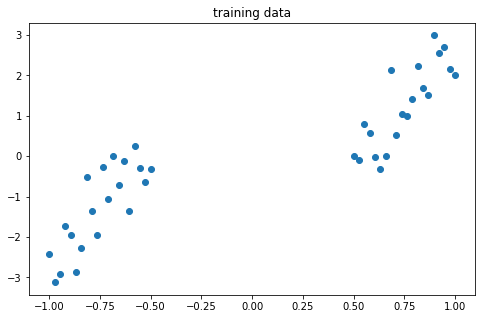

In [3]:
# Number of data points in each of the two segments of the domain
N = 20

# Observation noise variance
noise_variance = 0.3

# Generate toy data
x_train, y_train, x_test = generate_data(number_of_points=N, noise_variance=noise_variance)

# Plot the training data
plt.figure(figsize = (8,5))
plt.scatter(x_train, y_train)
plt.title('training data')
plt.show()

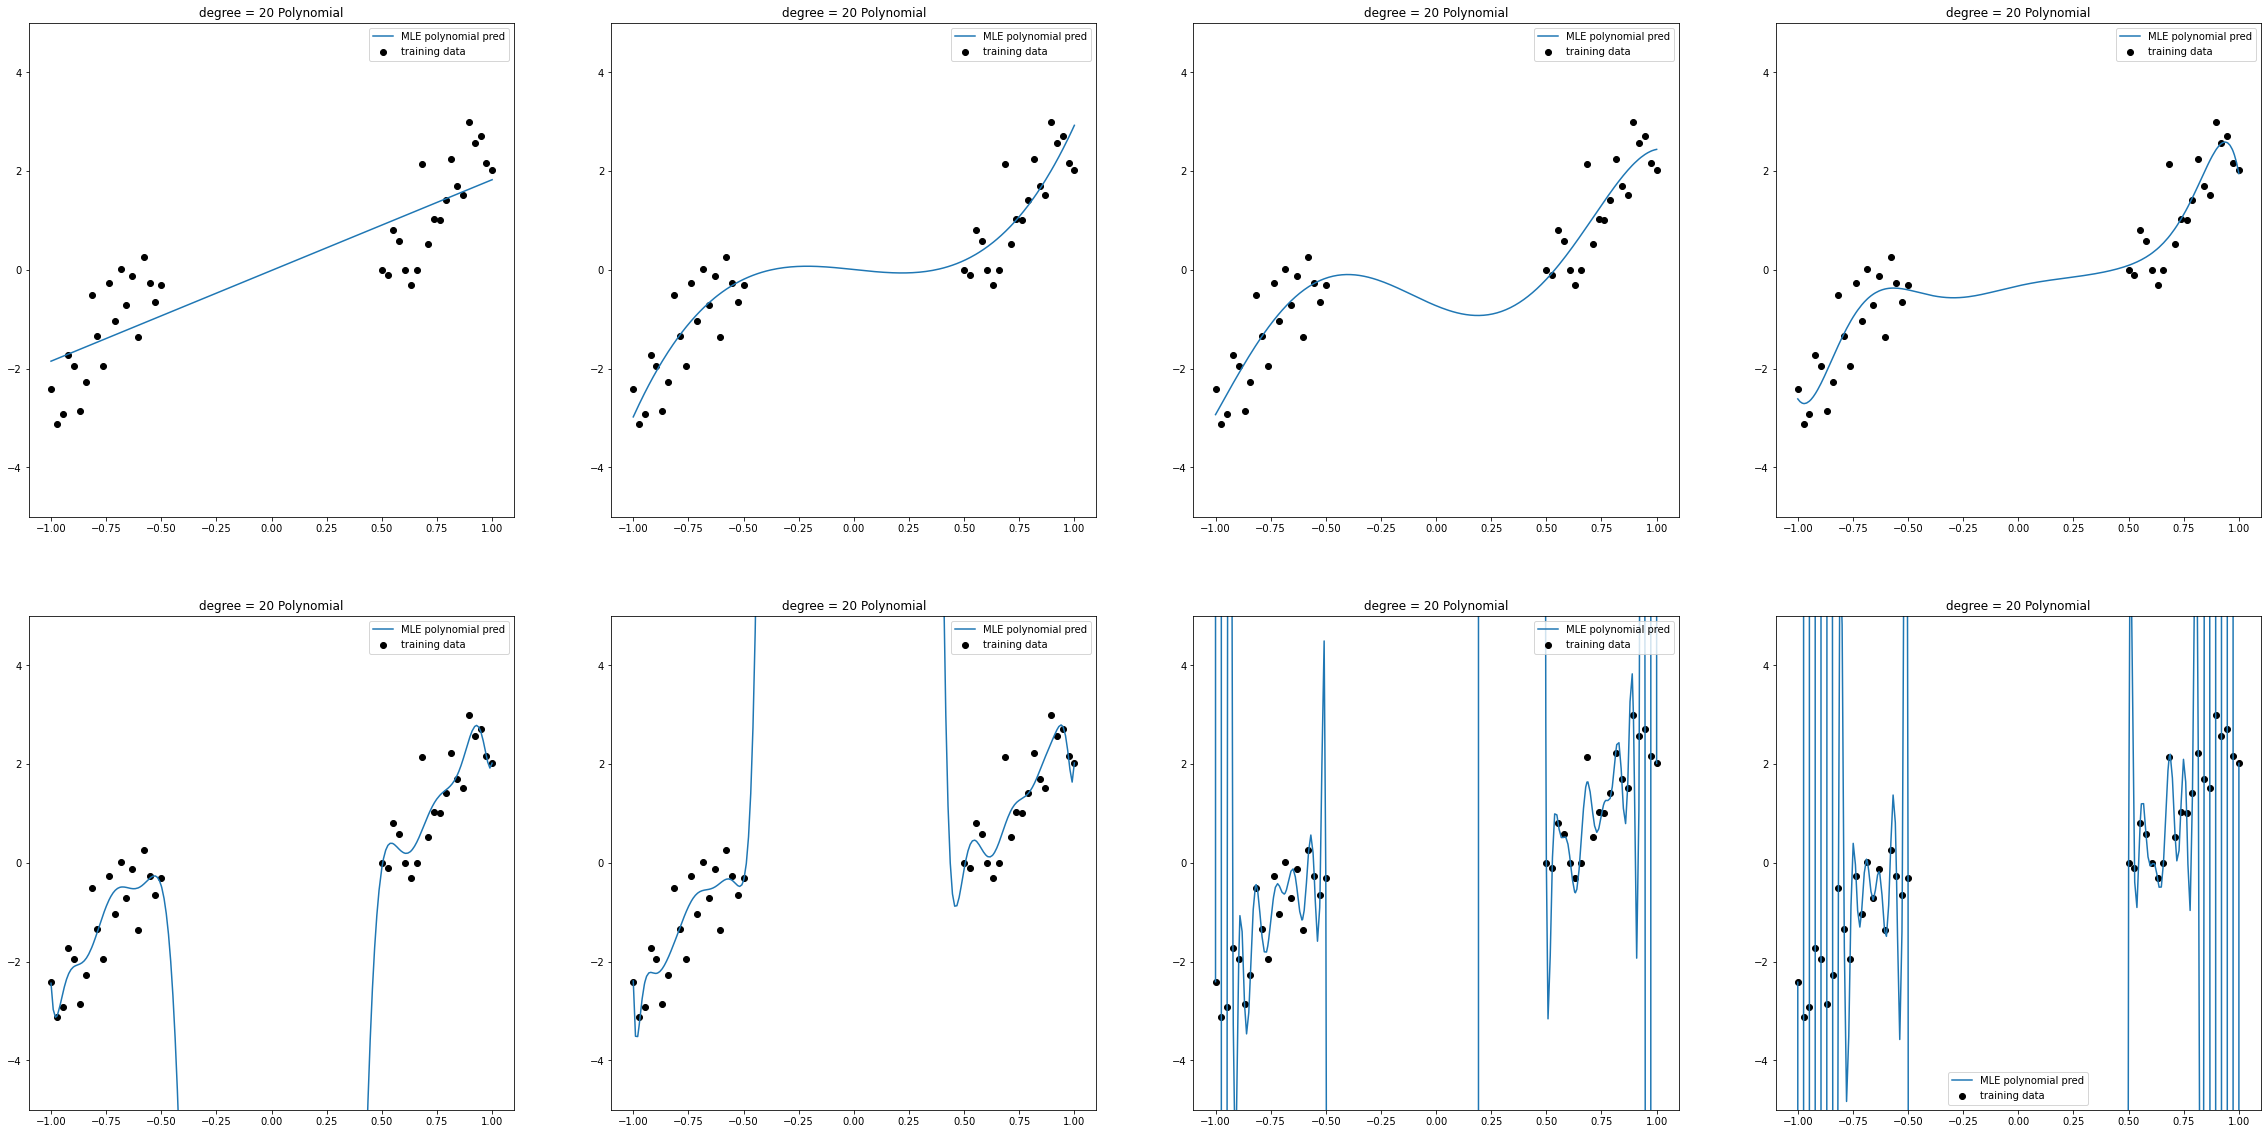

In [4]:
degrees = [1,3,5,10,15,20,50,100]

# Make a list to record all model predictions
y_train_pred = []
y_test_pred = []


fig, ax = plt.subplots(2, 4, figsize=(40, 20))

for k, deg in enumerate(degrees):      
    poly = PolynomialFeatures(deg)
    
    #intialize an LinearReg 
    linear_model = LinearRegression(fit_intercept=False)

    # Fit a polynomial model
    x_train_poly = poly.fit_transform(x_train.reshape((-1, 1)))
    x_test_poly = poly.fit_transform(x_test.reshape((-1, 1)))
    
    linear_model.fit(x_train_poly, y_train)

    # Predict on x_test_poly
    y_train_poly =  linear_model.predict(x_train_poly)
    y_test_poly = linear_model.predict(x_test_poly)
    y_train_pred.append(y_train_poly)
    y_test_pred.append(y_test_poly)
    
    #format into np array
    y_train_poly = np.array(y_train_poly)
    y_test_poly = np.array(y_test_poly)

    # Plot the training data
    i,j = k//4, k%4
    ax[i,j].scatter(x_train, y_train, color='black', label='training data')
    ax[i,j].plot(x_test, y_test_poly, label='MLE polynomial pred')
    ax[i,j].set_ylim([-5, 5])
    ax[i,j].set_title('degree = {} Polynomial'.format(N, deg))
    ax[i,j].legend(loc='best')

plt.show()

<font color='#00007B'>
Effect of the choice of polynomial degree on the fit of the model
   
**Answer:** 

With the increase of polynomial degree, the model appear to be more and more overfitting, and are easy to be affected by a single datapoint.
    
* When degree = 1, linear model seems to be too simple to fit the data and was unable to capture variations in dataset;
* When degree = 3 and 5, the model appear to fit data best;
* When degree >= 10, the model begins to overfit, capturing random fluctuations in dataset, interpolate each data point. These choices are unideal in the context of the problem. Those model has too high degree of polynomial and could be vulnerable to a single point change in data, and will change drastically due to disturbance of one data point. The uncertainty level of prediction in range x between [-0.5, 0.5] is also quite high, with predictions of y out of original y data range [-4,4].
    
One thing to note is that our training data is pretty small with only 40 data points, thus a high degree polynomial tends to overfit when come to such a small dataset. In terms of `covaraite shift`, it may also become pretty uncertain for data in the [-.5,.5] range as the model didn't have any training data from that range. For a training data that has a gap with no data in the middle range, it is as expected to observe some uncertainty in the range that x training data are missing.



2. **(Model Selection)** Later in the course, we will study a number of metrics commonly used for selecting between different MLE models. All of these metric essentially encode Occam's Razor: select the minimal complexity of model that satisfies some pre-determined modeling goal. <br><br>
For now, a very simple method for selecting the optimal degree is via cross-validation (by bootstrap):

  1. randomly sample two datasets, `x_train`, `x_valid`, from the data generating function: one for training and one for validation. Fit an MLE  polynomial model of degree $d$ on the training data and evaluate its performance on the validation data. Over $S$ number of such randomly sampled pairs of datasets, average the model's validation performance.
  2. plot the validation score as a function of model complexity, the polynomial degree $d$. 
  3. based on the plot, select the the minimal degree that achieves a high average validation performance (i.e. look for the 'elbow' of the plot).

  Explain why performing model selection by cross-validation mitigates the risk of choosing an undesirable polynomial (identified in Problem 1)?<br><br>
  Implement model selection by cross-validation for the toy dataset generated in Problem 1 using MSE as your performance metric and select an optimal degree from $D=[1,3,5,10,15,20,50,100]$.

In [5]:
from sklearn.metrics import mean_squared_error

degrees = [1,3,5,10,15,20,50,100]
S = 100
cross_validation_error = []

for d in degrees:
    mse = []
    for trial in range(S):
        # randomly sample two datasets
        x_train, y_train, _ = generate_data(number_of_points=N, noise_variance=noise_variance)
        x_valid, y_valid, _ = generate_data(number_of_points=N, noise_variance=noise_variance)
        
        poly = PolynomialFeatures(d)
    
        #intialize an LinearReg 
        linear_model = LinearRegression(fit_intercept=False)

        # Fit a polynomial model
        x_train_poly = poly.fit_transform(x_train.reshape((-1, 1)))
        x_valid_poly = poly.fit_transform(x_valid.reshape((-1, 1)))
    
        linear_model.fit(x_train_poly, y_train)
        
        # Predict on x_valid_poly
        y_valid_pred =  linear_model.predict(x_valid_poly)
    
        # calculate mse
        mse.append(mean_squared_error(y_valid_pred, y_valid))

    # average of model validation performance
    cross_validation_error.append(np.mean(mse))

In [6]:
cross_validation_error

[0.5650621949733331,
 0.3235859870908523,
 0.3457970929321447,
 0.38632901398768843,
 0.41230191341699174,
 0.46296079737895035,
 0.5934393900033551,
 0.6074174370978391]

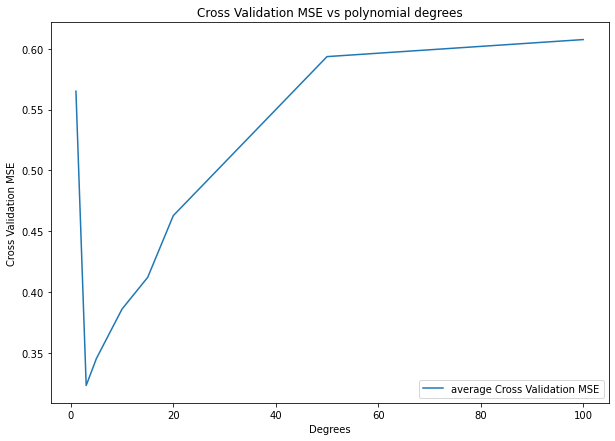

In [7]:
plt.figure(figsize=(10,7))
plt.plot(degrees, cross_validation_error, label = 'average Cross Validation MSE')
plt.xlabel('Degrees')
plt.ylabel('Cross Validation MSE')
plt.title('Cross Validation MSE vs polynomial degrees')
plt.legend(loc='lower right')
plt.show()

<font color='#00007B'>

**Answer**：

* Turning point: The elbow of the graph should be around `degree = 3`; Thus, based on the plot, the minimal degree that achieves a high average validation performance is polynomial degree 3, which is our model selection here by cross validation method.
    
Performing model selection by cross-validation mitigates the risk of choosing an undesirable polynomial, as visual image in problem 1 is unsafe to quantitatively draw conclusion about which degree fits the model best. We could say degree 3 and 5 fit model pretty well, or even degree 10, and the visual graph looks similar to each other. It is hard to choose a model between them purely by visual representation even with Occam's Razor principle (simplest model to explain). By average various trials of cross validation MSE on multiple datasets, we also mitigate the risk of validation dataset sampling bias that leads to misleading MSE in evaluating model performance, reducing the influence of randomness in datasets. 
Besides, for those overfitting model, it is easy to observe that they display a relatively high MSE comparing to degree 3 and 5, as they overfit and interpolate data, the MSE in validation dataset would be larger. 

3. **(Uncertainty Estimation)** As you have seen in HW0, we often use the bootstrap predictive uncertainty of MLE models as an indicator of our confidence in the model's output. Increasingly, in practice, decisions making are deferred to human experts when the model's predictive uncertainty is too high. <br><br>
Given your understanding of the dataset (`x_train` and `x_test`), describe what the model uncertainty ***should*** ideally look like across the input space (i.e. if you plotted the model uncertainty as a function of $x$, what would it look like)? Justify your answer: consider the context of the problem - the test input has undergone covariate shift and is dissmilar to the training input, what kind of uncertainty would help you mitigate risk under this condition?<br><br>
A common practice for estimating predictive uncertainty is to fit a large number of (bootstrap) models on the training data (this collection of models is called an **ensemble**), then, at an input $x$, use the variance of the ensemble predictions to estimate the uncertainty at $x$. Plot the 95% predictive interval of 200 bootstrap MLE polynomial models for each degree $D=[1,3,5,10,15,20,50,100]$, arrange your plots as  subplots in a single figure. For which polynomial degree do you obtain the predictive uncertainty that is most ideal (according to your description above)? Is this the degree you selected in Problem 2? Explain why you would or would not expect the optimal degree in Problem 2 to yield the most ideal uncertainty estimate.<br><br>
Make the same plots the 95% predictive intervals for degrees $D=[1,3,5,10,15,20,50,100]$, with models fitted on larger training datasets - set `number_of_points` to 50, 100, 500, 1000 (arrange all these plots in a single figure). What is happening to the predictions of the ensemble in the training data rich region? What is happening to the predictions of the ensemble in the training data poor region? Are these expected behaviours (relate what you see in both cases to the asymptotic properties of MLE)?
<br><br>
When the training data is abundant (`number_of_points=1000`), are any of the 95% predictive intervals ideal (according to your description above)? What does this imply about the feasibility of using the variance of the ensemble predictions to estimate predictive uncertainty at an input $x$?

<font color='#00007B'>

**Answer**：
    
* Expectation of model uncertainty: Model uncertainty should ideally be larger across input space where training data x is missing, as we didn't see any previous information of data in that range `[-.5, .5]`. Consider the context of the problem, the test input has undergone covariate shift and have observe no data in middle part, thus when we fit polynomial model and make prediction, we would naturally want higher uncertainty for new observations in test data that appeared in a data range that we never see before. It is similar to deferring decision making to human experts when the predictive uncertainty is too high, we would probably choose to defer decision to human experts when the data is far from what we've been observed in test data. For example, for data around 0, we want model show highest uncertainty and mitigate the risk by deferring decision making to human experts. For data around 0.5, we could expect model to have slightly lower uncertainty comparing to test x=0, as it is closer to observed training data.
    

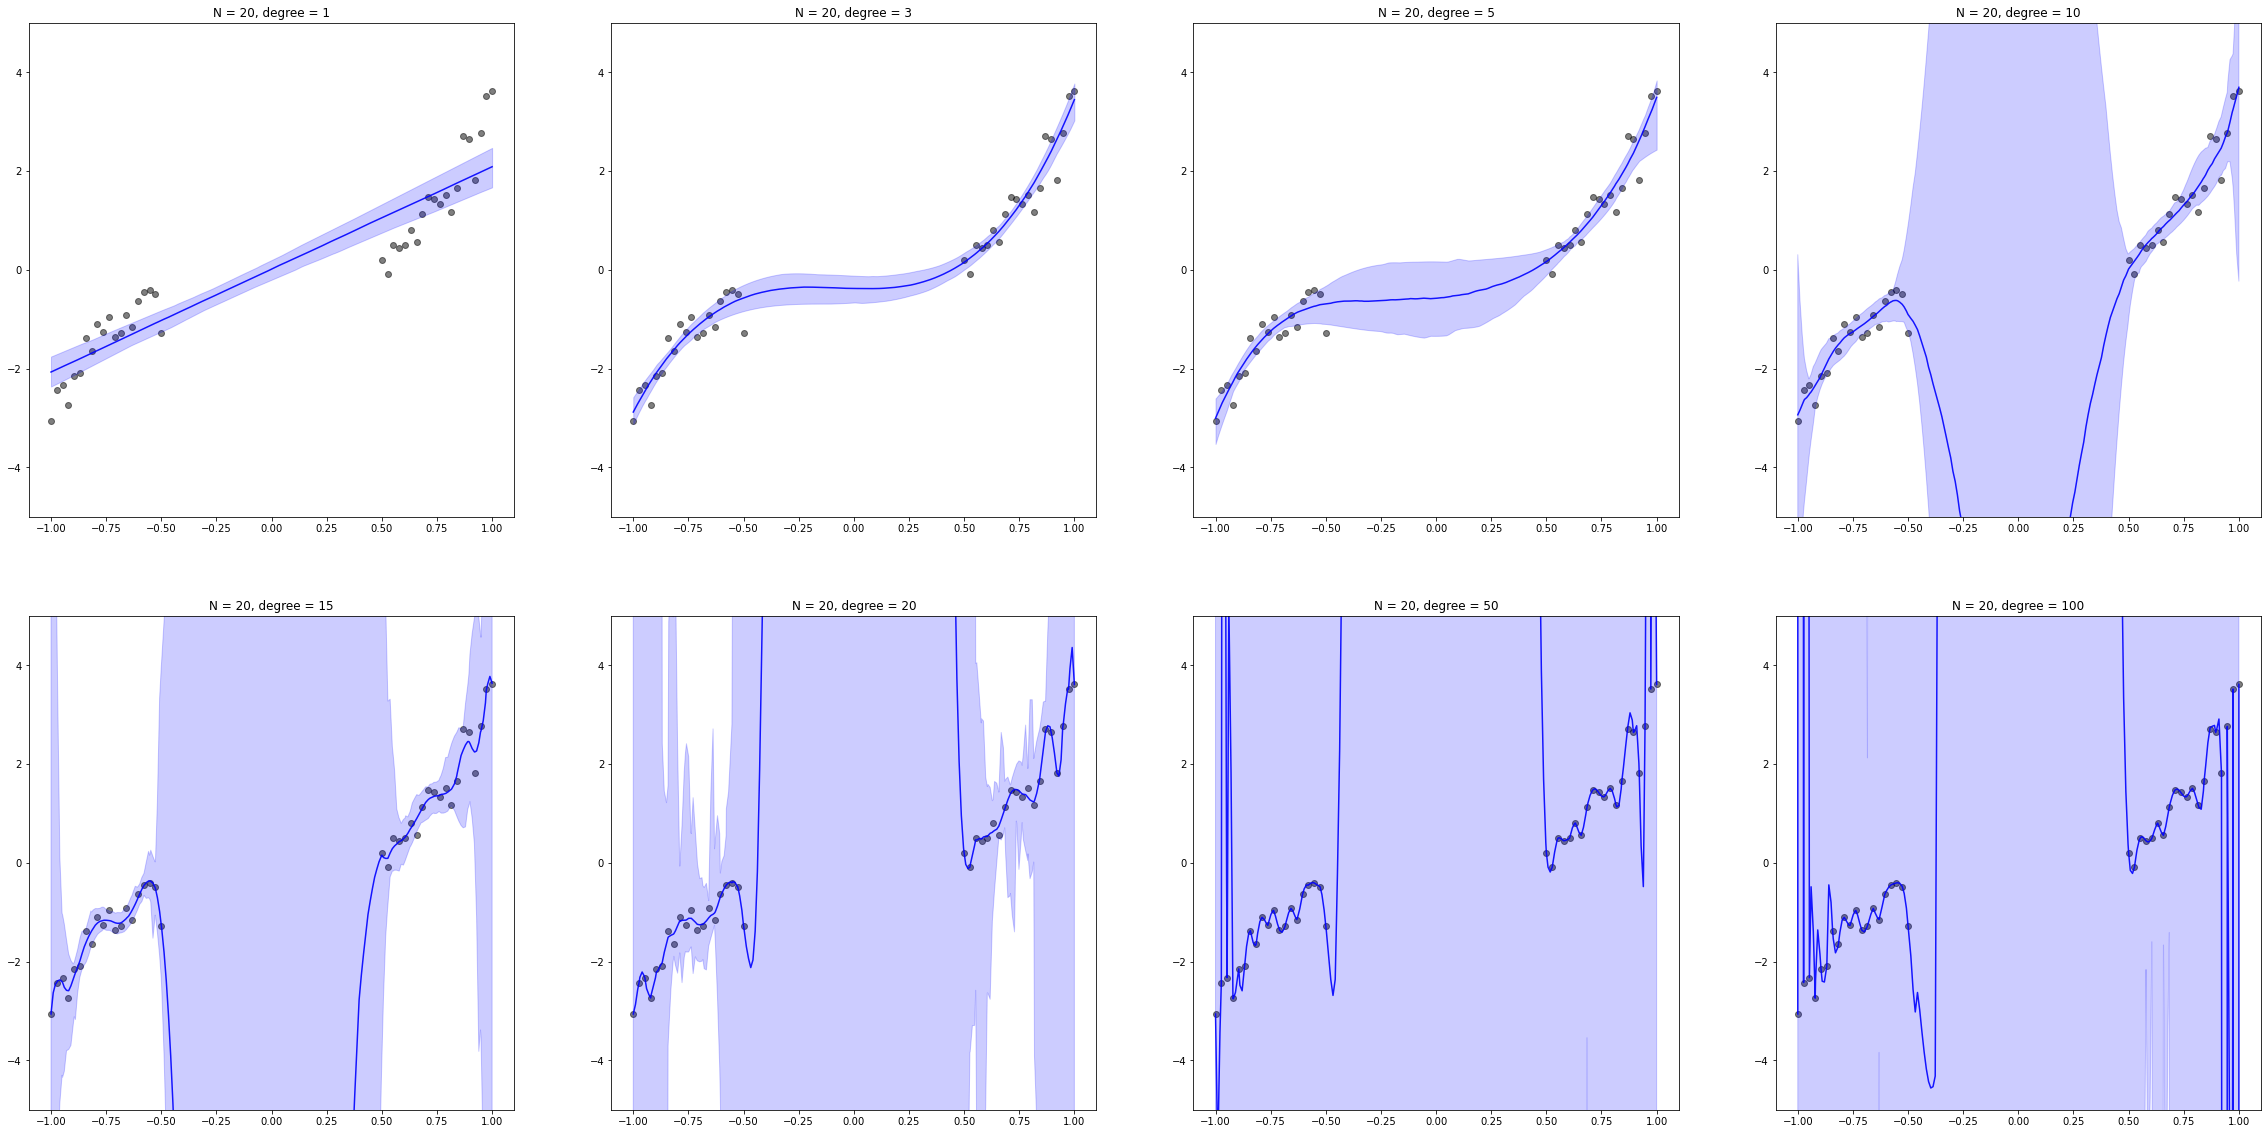

In [8]:
# training dataset N = 20
degrees = [1,3,5,10,15,20,50,100]

trials = 200

fig, ax = plt.subplots(2, 4, figsize=(40, 20))


for k, deg in enumerate(degrees):     
    poly = PolynomialFeatures(deg)
    linear_model = LinearRegression(fit_intercept=False)

    # Number of boostrap polyomial models to fit
    # Make a list to record all model predictions
    y_test_poly = []

    # Bootstrap 200 training sets and fit a polynomial regression model on each
    for i in range(trials):

        # Generate a bootstrap sample from the data
        indices = np.random.choice(np.arange(len(x_train)), size=len(x_train))
        bootstrap_x = x_train[indices]
        bootstrap_y = y_train[indices]

        # Fit a polynomial model
        bootstrap_x_poly = poly.fit_transform(bootstrap_x.reshape((-1, 1)))
        bootstrap_x_test_poly = poly.fit_transform(x_test.reshape((-1, 1)))
        linear_model.fit(bootstrap_x_poly, bootstrap_y)

        # Predict on x_test
        y_test = linear_model.predict(bootstrap_x_test_poly)
        y_test_poly.append(y_test)

    y_test_poly = np.array(y_test_poly)

    # Compute the 97.5 th percentile of the posterior predictive predictions
    y_test_poly_ub = np.percentile(y_test_poly, 97.5, axis=0)

    # Compute the 50 th percentile of the posterior predictive predictions
    y_test_poly_mean = np.percentile(y_test_poly, 50.0, axis=0)

    # Compute the 2.5 th percentile of the posterior predictive predictions
    y_test_poly_lb = np.percentile(y_test_poly, 2.5, axis=0)

    # Plot the training data
    i,j = k//4, k%4

    ax[i,j].scatter(x_train, y_train, color='black', alpha = 0.5, label='data')

    # Plot 95% predictive interval
    ax[i,j].fill_between(x_test, y_test_poly_ub, y_test_poly_lb, color='blue', alpha=0.2)
    ax[ i,j ].plot(x_test, y_test_poly_mean, color='blue', alpha=0.9)

    ax[ i,j ].set_ylim([-5, 5])
    ax[ i,j ].set_title('N = {}, degree = {}'.format(N, deg))

plt.show()

<font color='#00007B'>

**Answer**：
    
For which polynomial degree do you obtain the predictive uncertainty that is most ideal (according to your description above)? Is this the degree you selected in Problem 2? Explain why you would or would not expect the optimal degree in Problem 2 to yield the most ideal uncertainty estimate.
    
* From above description and visual graph, *degree = 5* obtain the predictive uncertainty that is most ideal. It has higher uncertainty in the part where x training data is missing, and uncertainty gets higher in the region where x approaches to 0 (i.e. furthest away from observed training data). It has the highest uncertainty level in the part that is furthest away from observed data.

* degree = 1 obviously shows constant uncertainty across all x, meaning it is as certain for x region where convariate shift happens and no previous observed data exist as the other x. This doesn't corresponds to my description of uncertainty we expected to have.
    
* degree = 3 has higher uncertainty in middle part, but it is generally constant across all middle part where x training data is missing. It doesn't display any pattern for which missing x is more uncertain than others. Ideally, I would expect the 95% region in middle part have heavy belly in middle as these are the part that is furthest away from existing training data.
    
* for model with degree >= 10, their uncertainty level is too high across all x that has convariate shift. Besides, some of them even are extremely uncertain in the part where there exists x training data. I would not bother to use a model with such high uncertainty.
    
> Thus, I will choose model with degree =5, which is different from the degree=3 selected in Problem 2.
In problem 2, we choose degree by Occam's Razor rule, selecting the minimal complexity of model that satisfies some pre-determined modeling goal, acheiving minimal cross validation MSE. Here we select degree based on our expectation of how uncertainty would looks like. This two doesn't conflict as they are looking at different aspects. The elbow method in problem 2 could capture trends in training data and make good prediction with minimal error, however it fails to look at uncertainty in its cross validation. To combine two methods, degree 5 could be a good choice with ideal uncertainty region and also a relatively low complexity, as well as low cross validation MSE.

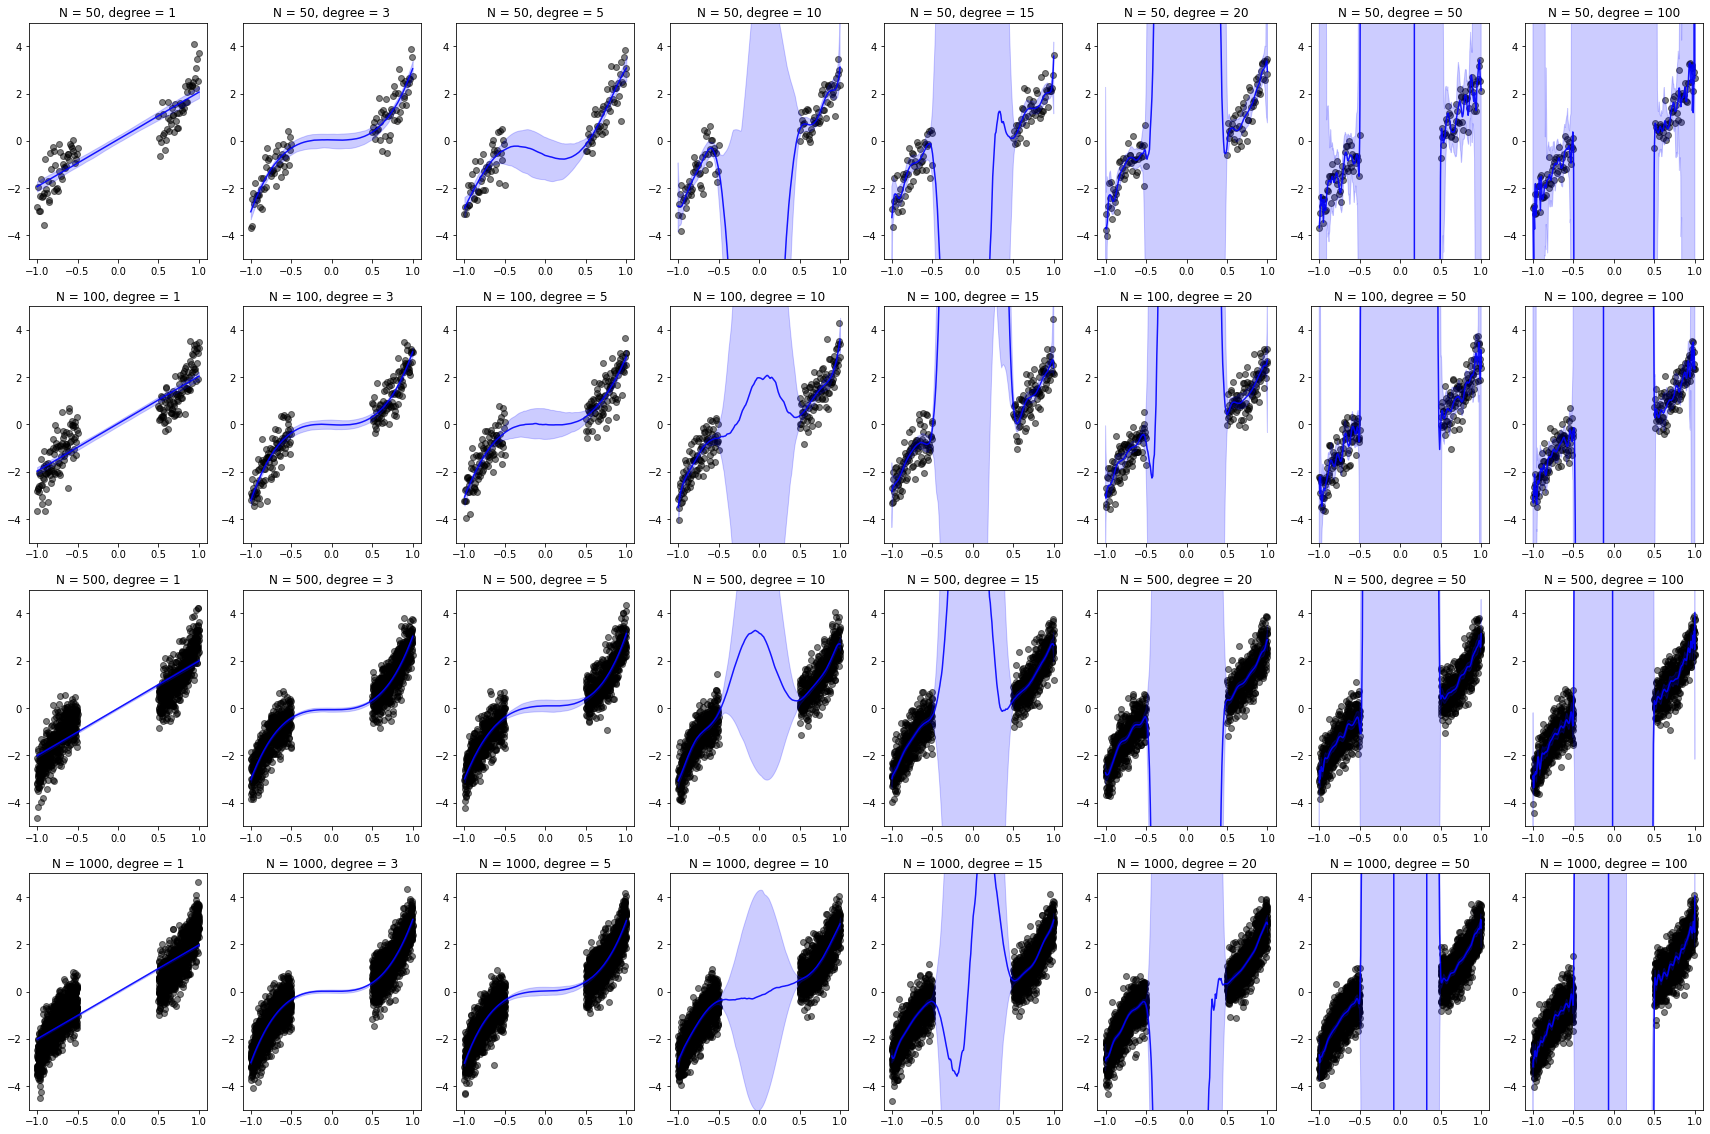

In [9]:
# model fit on larger training datasets
n_points = [50, 100, 500, 1000]
degrees = [1,3,5,10,15,20,50,100]

trials = 200

fig, ax = plt.subplots(len(n_points), len(degrees), figsize=(30, 20))


for j, N in enumerate(n_points):
    for k, deg in enumerate(degrees):
                
        x_train, y_train, x_test = generate_data(number_of_points=N, noise_variance=noise_variance)

        poly = PolynomialFeatures(deg)
        linear_model = LinearRegression(fit_intercept=False)

        # Number of boostrap polyomial models to fit
        # Make a list to record all model predictions
        y_test_poly = []

        # Bootstrap 200 training sets and fit a polynomial regression model on each
        for i in range(trials):
                
            # Generate a bootstrap sample from the data
            indices = np.random.choice(np.arange(len(x_train)), size=len(x_train))
            bootstrap_x = x_train[indices]
            bootstrap_y = y_train[indices]
            
            # Fit a polynomial model
            bootstrap_x_poly = poly.fit_transform(bootstrap_x.reshape((-1, 1)))
            bootstrap_x_test_poly = poly.fit_transform(x_test.reshape((-1, 1)))
            linear_model.fit(bootstrap_x_poly, bootstrap_y)

            # Predict on x_test
            y_test = linear_model.predict(bootstrap_x_test_poly)
            y_test_poly.append(y_test)
        
        y_test_poly = np.array(y_test_poly)

        # Compute the 97.5 th percentile of the posterior predictive predictions
        y_test_poly_ub = np.percentile(y_test_poly, 97.5, axis=0)

        # Compute the 50 th percentile of the posterior predictive predictions
        y_test_poly_mean = np.percentile(y_test_poly, 50.0, axis=0)

        # Compute the 2.5 th percentile of the posterior predictive predictions
        y_test_poly_lb = np.percentile(y_test_poly, 2.5, axis=0)

        # Plot the training data
        ax[j, k].scatter(x_train, y_train, color='black', alpha = 0.5, label='data')

        # Plot 95% predictive interval
        ax[j, k].fill_between(x_test, y_test_poly_ub, y_test_poly_lb, color='blue', alpha=0.2)
        ax[j, k].plot(x_test, y_test_poly_mean, color='blue', alpha=0.9)

        ax[j, k].set_ylim([-5, 5])
        ax[j, k].set_title('N = {}, degree = {}'.format(N, deg))

plt.show()

<font color='#00007B'>

**Answer**：
    
What is happening to the predictions of the ensemble in the training data rich region? What is happening to the predictions of the ensemble in the training data poor region? Are these expected behaviours (relate what you see in both cases to the asymptotic properties of MLE)?
    
> When the ensemble in the training data rich region (last row), the prediction uncertain become smaller and smaller, especially for degree <= 10, the uncertainty region shrinks; for degree < 5, the uncertainty region seems to be constant across all x with low level of uncertainty and a small 95% CI. For x region where training data exists, as data gets richer, they become quite certain for all degree levels. At high degree level, though, in the region where x training data is missing, uncertainty level is still extremely even with increasing number of observations.

> The asymptotic properties of maximum likelihood estimators says that MLE estimator will converge the true data distribution as N goes to infinity, so does its consistency property describes. In all bootstrap models, with larger N, variance become smaller as estimator converge to groundtruth distribution. Thus, this is expected behaviour to see predictions 95% CI shrink to a thin tube in data rich region. However, it seems consistency of MLE and asymptotic properties doesn't hold for data poor rich, though their uncertainty level also shrinks a little bit, it is still having high uncertainty and didn't converge to a set of more certain predictions even with larger N. This may be due to the reason that there exists many models or groundtruth distribution that could interpolate the gap region to make the observed training data make sense. As we are missing information over this region, we do not know anything about groundtruth model that could generate this data. Thus, it couldn't converge to a single model or single grouthtruth distribution even under large N, the consistency property doesn't show up here.

<font color='#00007B'>

When the training data is abundant (number_of_points=1000), are any of the 95% predictive intervals ideal (according to your description above)? What does this imply about the feasibility of using the variance of the ensemble predictions to estimate predictive uncertainty at an input  𝑥 ?
    
> When the training data is abundant, 95% predictive interval for degree = 10 seems to be more ideal according to my description above. It seems to have a heavy belly in gap region where training data is missing, with higher uncertainty when x close to 0. For degree = 3 and 5, the polynomial model is more certain that we expected, and with large N and rich training data, it converges to a groundtruth distribution that is more certain to have these training x. However, with degree = 10, it still displays desired uncertainty level. It could be infer that there is still feasibility of using the variance of the ensemble predictions to estimate predictive uncertainty, but when data gets larger, it may be  converge to a single distribution without giving you desired predictive uncertainty that you expected. Thus, it may be misleading, and we need to be more careful in choosing the right model when using variance of the ensemble predictions.
    
    
    

4. **(Effect of Regularization)** In practice, MLE models are nearly always trained with regularization (since they tend to overfit to the training data). Here, we will explore the effect of adding $\ell_2$ regularization to our MLE polynomial models (that is, use the `Ridge` regression model from `sklearn` after augmenting your input with polynomial features). <br><br>
For a toy dataset with 40 observations (`number_of_points=20`), plot the 95% predictive intervals for degrees $D = [1,3,5,10,15,20,50,100]$ and regularization strengths `alpha = [5e-3, 1e-2, 1e-1, 1e0, 1e1]` (you should organize these plots in a grid).<br><br>
Describe the effect of regularization on the bootstrap uncertainties. Looking at these results, are the goals of $\ell_2$ regularization and obtaining useful predictive uncertatinty estimation neccessarily well-aligned?


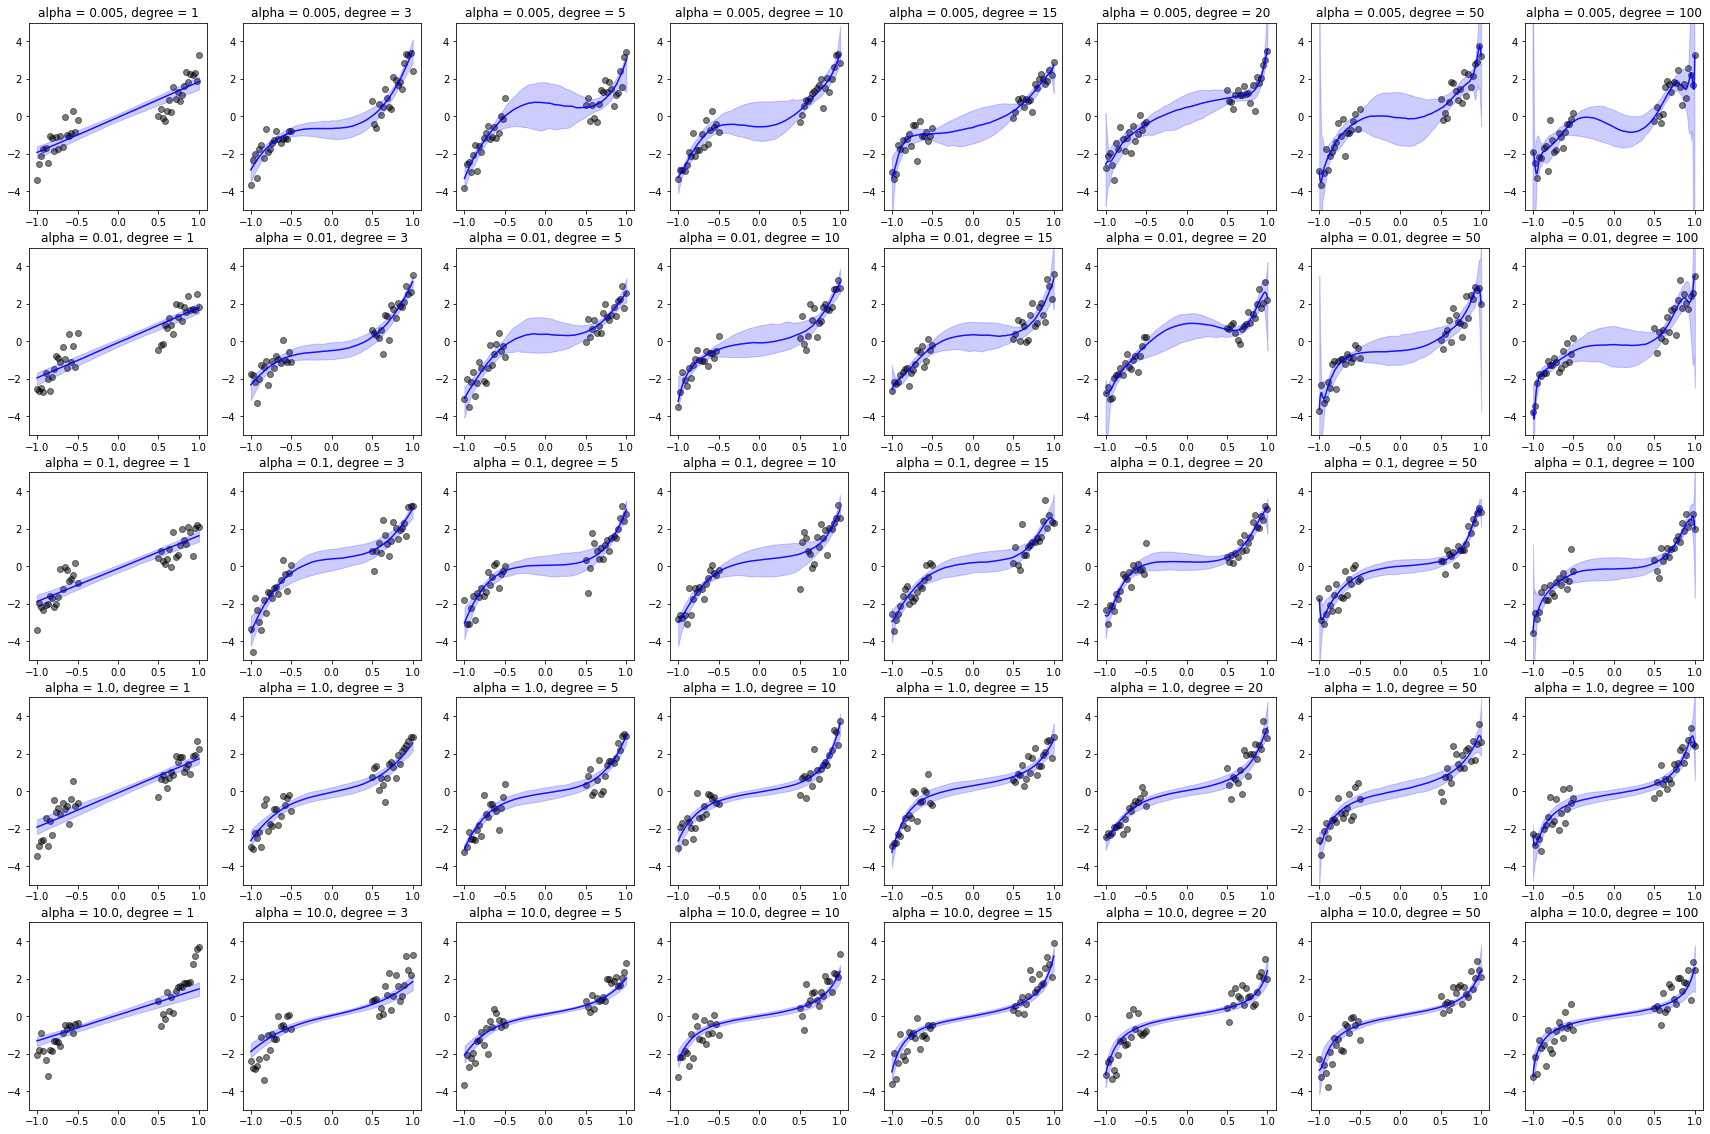

In [10]:
alpha = [5e-3, 1e-2, 1e-1, 1e0, 1e1]
degrees = [1,3,5,10,15,20,50,100]
N = 20
trials = 200

fig, ax = plt.subplots(len(alpha), len(degrees), figsize=(30, 20))

for j, a in enumerate(alpha):
    for k, deg in enumerate(degrees):       
        x_train, y_train, x_test = generate_data(number_of_points=N, noise_variance=noise_variance)

        poly = PolynomialFeatures(deg)
        linear_model_with_reg = Ridge(alpha = a, fit_intercept=False)

        # Number of boostrap polyomial models to fit
        # Make a list to record all model predictions
        y_test_poly = []

        # Bootstrap 200 training sets and fit a polynomial ridge regression model on each
        for i in range(trials):
                
            # Generate a bootstrap sample from the data
            indices = np.random.choice(np.arange(len(x_train)), size=len(x_train))
            bootstrap_x = x_train[indices]
            bootstrap_y = y_train[indices]
            
            # Fit a polynomial model
            bootstrap_x_poly = poly.fit_transform(bootstrap_x.reshape((-1, 1)))
            bootstrap_x_test_poly = poly.fit_transform(x_test.reshape((-1, 1)))
            linear_model_with_reg.fit(bootstrap_x_poly, bootstrap_y)

            # Predict on x_test
            y_test = linear_model_with_reg.predict(bootstrap_x_test_poly)
            y_test_poly.append(y_test)
        
        y_test_poly = np.array(y_test_poly)

        # Compute the 97.5 th percentile of the posterior predictive predictions
        y_test_poly_ub = np.percentile(y_test_poly, 97.5, axis=0)

        # Compute the 50 th percentile of the posterior predictive predictions
        y_test_poly_mean = np.percentile(y_test_poly, 50.0, axis=0)

        # Compute the 2.5 th percentile of the posterior predictive predictions
        y_test_poly_lb = np.percentile(y_test_poly, 2.5, axis=0)

        # Plot the training data
        ax[j, k].scatter(x_train, y_train, color='black', alpha = 0.5, label='data')

        # Plot 95% predictive interval
        ax[j, k].fill_between(x_test, y_test_poly_ub, y_test_poly_lb, color='blue', alpha=0.2)
        ax[j, k].plot(x_test, y_test_poly_mean, color='blue', alpha=0.9)

        ax[j, k].set_ylim([-5, 5])
        ax[j, k].set_title('alpha = {}, degree = {}'.format(a, deg))

plt.show()

<font color='#00007B'>

**Answer**：
    
Describe the effect of regularization on the bootstrap uncertainties. Looking at these results, are the goals of L2  regularization and obtaining useful predictive uncertatinty estimation neccessarily well-aligned?
    
With heavy regularization, e.g. larger alpha, the bootstrap uncertainties has been reduced sharply. When alpha = 10, it looks almost certain and have constantly uncertainty level throughout all x region even with covariate shift or high degree of polynomial.
    
When alpha < 1, the displayed predictive uncertainty aligns with my expectation. The regularization greatly reduced extreme uncertainty level when degree is higher than 10, so the 95% CI become smaller and not covering the whole screen. Besides, it also still keeps higher uncertainty level when comes to x with covariate shift and unseen training data. They seem to have heavy belly that indicating higher uncertainty around x = 0, which is furthest away from what we observed in training data.

However with alpha >=1, the regularization restricted uncertainty level and make the model become quite certain. The uncertainty is constant across all x, even with high degree of polynomial and unseen x training data. This doesn't align with our expectation. I think the regularization is too strong that it rule out uncertainties in the data gap where covariate shift happens. It prevents us from overfitting or have extreme predictions, however it also make uncertainty shrink.

Thus to summarize, L2 regularization with large/heavy alpha doesn't make sense, it may underfit and eliminate our expected uncertainty level in the region where x training data is missing. With smaller alpha regularization coefficient, it may be possible to prevent overfit but still maintain expected uncertainty level. In total, the goal of L2 reg and obtaining useful predictive uncertainty estimation doesn't neccesarily well aligned.

## Part II: Bayesian Polynomial Regression
In this problem, your task is to perform Bayesian polynomial regression on the toy datasets in Part I. That is, assume that the outcome $y$ can be modeled by the following process:

\begin{align}
y &= f(x) + \epsilon = w_0 + w_1x + w_2x^2 + \ldots + w_Dx^D + \epsilon, \quad \epsilon \sim \mathcal{N}(0, 0.3)\\
w_d &\sim \mathcal{N}(0, \alpha)
\end{align}

where $\alpha$ is a hyperparameter and must be fixed before modeling and inference begins.

1. **(Bayesian Kernel Regression)** Just as we can treat a polynomial regression model like a multi-linear regression model after ***transforming*** the input data by adding polynomial features. We can treat Bayesian polynomial regression like Bayesian linear regression on top of the transformed inputs. Formally, the map that takes an input $\mathbf{x}_n \in \mathbb{R}^{D'}$ and transforms it into a new input $\phi(\mathbf{x}_n) \in \mathbb{R}^{D}$ is called a **feature map**, $\phi: \mathbb{R}^{D'} \to \mathbb{R}^{D}$, for 1-dimensional input $x \in \mathbb{R}$, the polynomial feature map of degree $D$ is defined by
\begin{align}
\\\phi: \mathbb{R} &\to \mathbb{R}^D\\
x &\mapsto [1, x, x^2, \ldots, x^D]\\
\end{align}
<br> Thus, we can write rewrite Bayesian polynomial regression as
\begin{align}
\\y &= \mathbf{w}^\top \mathbf{x} + \epsilon, \quad \epsilon \sim \mathcal{N}(0, 0.3)\\
\mathbf{w} &\sim \mathcal{N}(0, \alpha I_{D\times D})\\
\end{align}
<br>Denote the $N\times D$ matrix of transformed inputs by $\Phi$, where the $n$-th row of the matrix is the $n$-th input $\mathbf{x}_n$ transformed by the feature map, $\phi(\mathbf{x}_n)$. Using this notation, write out the closed form for the posterior for Bayesian polynomial regression in terms of $\Phi$ (you don't need to rederive anything, just make the appropriate substitutions in the formula you derived in HW0).

<font color='#00007B'>

**Answer**：

From HW0, $$\frac{\left(\prod_{n=1}^Np(y_n|x_n, w_1, w_0)\right)p(w_1)p(w_0)}{\prod_{n=1}^Np(y_n|x_n)}$$
    
 \begin{aligned}
= p(w|\mathbf{y},\mathbf{X}) = \frac{p(\mathbf{y}|\mathbf{X},w)p(w)}{p(\mathbf{y}|\mathbf{X})} \propto p(\mathbf{y}|\mathbf{X},w)p(w),
\end{aligned}
    
  
$$=\frac{1}{2\pi*\sqrt{|M^{-1}|}} * \mathrm{exp}\left\{-\frac{1}{2}(w-M^{-1}N)^T(M)(w-M^{-1}N)\right\}$$
    
$$ \sim \mathcal{N}(w; M^{-1}N, M^{-1})$$
 
It follows multivariate normal distribution, with mean $M^{-1}N$ and variance $M^{-1}$.
    
with $M=\frac{1}{\sigma_\epsilon^2} \mathbf{X}^T\mathbf{X}+\Sigma^{-1}$ and $N=(\frac{1}{\sigma_\epsilon^2})\mathbf{X}^T\mathbf{y}$


the posterior mean is 
$$ M^{-1}N = (\frac{1}{\sigma_\epsilon^2} \mathbf{X}^T\mathbf{X}+\Sigma^{-1})^{-1}(\frac{1}{\sigma_\epsilon^2})\mathbf{X}^T\mathbf{y}$$
    
posterior variance is $$M^{-1} = (\frac{1}{\sigma_\epsilon^2} \mathbf{X}^T\mathbf{X}+\Sigma^{-1})^{-1} $$

<font color='#00007B'>
    
Here, we plugging in
    
$$\mathbf{X} = \Phi$$ 
    
$$\sigma_\epsilon^2 = 0.3 * I_{D\times D}$$ 
    
$$\Sigma^{-1} = (\alpha I_{D\times D})^{-1} = I_{D\times D} \alpha^{-1}$$

Posterior mean is 
    
$$(\frac{1}{\sigma_\epsilon^2} \mathbf{X}^T\mathbf{X}+\Sigma^{-1})^{-1}(\frac{1}{\sigma_\epsilon^2})\mathbf{X}^T\mathbf{y}$$
    
$$ = (\frac{10}{3}I_{D\times D} \Phi^T\Phi +I_{D\times D} \alpha^{-1})^{-1}(\frac{10}{3}I_{D\times D})\Phi^T \mathbf{y}$$
    
$$ = (\frac{10}{3}\Phi^T\Phi +I_{D\times D} \alpha^{-1})^{-1}(\frac{10}{3})\Phi^T \mathbf{y}$$

    
Posterior variance is 
$$(\frac{1}{\sigma_\epsilon^2} \mathbf{X}^T\mathbf{X}+\Sigma^{-1})^{-1} $$
    
$$ = (\frac{10}{3}I_{D\times D} \Phi^T\Phi +I_{D\times D} \alpha^{-1})^{-1}$$
    
$$ = (\frac{10}{3} \Phi^T\Phi +I_{D\times D} \alpha^{-1})^{-1}$$
    
Thus the posterior for Bayesian polynomial regression in terms of $\Phi$ is:
    $$ \sim \mathcal{N}(\mathbf{w}; [\frac{10}{3}\Phi^T\Phi +I_{D\times D} \alpha^{-1}]^{-1}(\frac{10}{3})\Phi^T \mathbf{y}, [\frac{10}{3} \Phi^T\Phi +I_{D\times D} \alpha^{-1}]^{-1})$$

2. **(Effect of Model Complexity)** For Bayesian kernel regression, you need to pre-determine the number of features (i.e. $D$) and the hyperparameter $\alpha$ in the prior. For a toy dataset with 40 observations (set number_of_points=20), visualize the 95% posterior predictive interval for $D = [1,3,5,10,15,20,50,100]$ and $\alpha = [0.1, 1, 5, 10, 100]$ (arrange these visualizations in a grid), using Bayesian polynomial regression. 
<br><br>
Based on your visualizaion, describe in intuitive terms what is the role of $\alpha$ and $D$ in determining the shape of the posterior predictive uncertainty. 
<br><br>
***Hint:*** Read Problem 3 before implementing Problem 2, you can implement both at the same time.
<br><br>
**Extra Credit:** When the feature map $\phi$ is a general (usually non-linear transformation), applying Bayesian linear regression on the transformed input is called **Bayesian Kernel Regression**. Choose your own non-linear feature map $\phi: \mathbb{R} \to \mathbb{R}^5$ and visualize the 95% posterior predictive interval of the Bayesian kernel regression for your choice of $\phi$ and $D = [1,3,5,10,15,20,50,100]$, $\alpha = [0.1, 1, 5, 10, 100]$. Compare the visualization to the that for Bayesian polynomial regression. Does the posterior predictive of your Bayesian kernel regression capture important properties of the posterior predictive of the Bayesian polynomial regression model?
<br><br>
**Note:** we highly recommend that you implement the following feature map:
<br><br>
\begin{align}
\phi: \mathbb{R}^{D'} &\to \mathbb{R}^D\\
\mathbf{x} &\mapsto \left[\sqrt{\frac{2}{D}} \cos(w_1^\top x + b_1), \ldots, \sqrt{\frac{2}{D}} \cos(w_D^\top x + b_D)\right]
\end{align}
<br>where $b_d \sim [0, 2\pi]$ and $w_d \sim \mathcal{N}(0, \beta I_{D'\times D'})$ need to be randomly sampled and fixed before modeling and inference. For this exercise, we suggest setting $\beta=10$. The features generated by $\phi$ are called **Random Fourier Features**. As the number of features $D$ tends to infinity, the resulting Bayesian kernel regression model tends to an important type of Bayesian (nonparametric) model called Gaussian Process model. We will revisit the connection between Bayesian kernel regression and Gaussian processes in the latter part of the course.

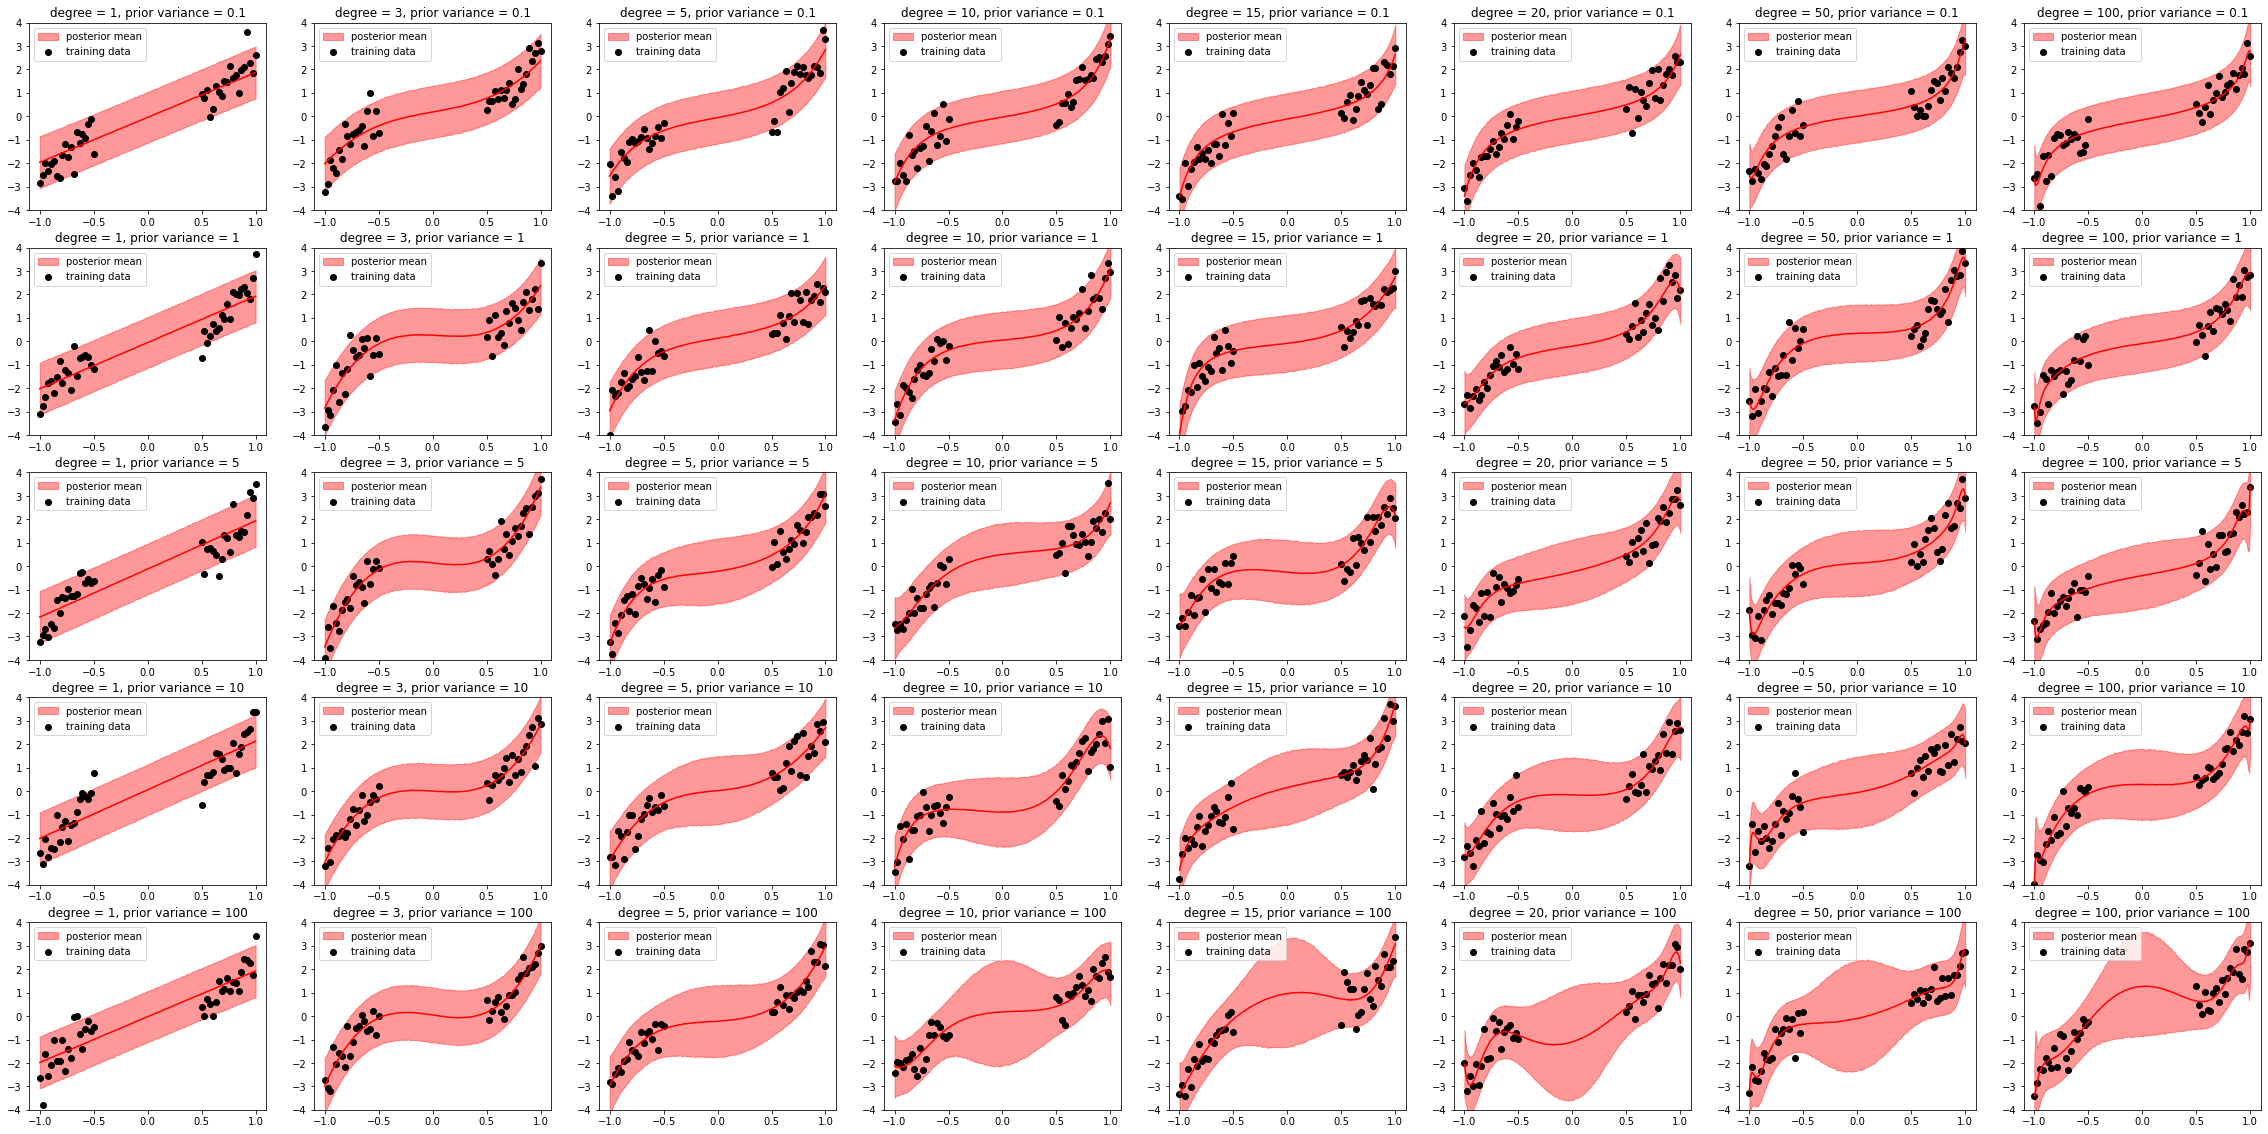

In [11]:
alpha = [0.1, 1, 5, 10, 100]
degrees = [1,3,5,10,15,20,50,100]

noise_variance = 0.3 
N = 20
trials = 200

fig, ax = plt.subplots(len(alpha), len(degrees), figsize=(40, 20))


for j, sig in enumerate(alpha):
    for k, deg in enumerate(degrees):       
        x_train, y_train, x_test = generate_data(number_of_points=N, noise_variance=noise_variance)
        
        # Make an instance of the PolynomialFeatures model to add polynomial powers to our covariates
        poly = PolynomialFeatures(deg)

        # Fit our PolynomialFeatures to our data and add add polynomial powers to our covariates
        x_train_poly = poly.fit_transform(x_train.reshape((-1, 1)))
        x_test_poly = poly.fit_transform(x_test.reshape((-1, 1)))

        # Get samples from the posterior predictive
        posterior_predictions, posterior_predictive_samples = get_posterior_samples(sig, noise_variance, x_train_poly, y_train.reshape((-1, 1)), x_test_poly, trials)

        # Compute the 97.5 th percentile of the posterior predictive predictions
        pp_upper = np.percentile(posterior_predictive_samples, 97.5, axis=0)

        # Compute the 2.5 th percentile of the posterior predictive predictions
        pp_lower = np.percentile(posterior_predictive_samples, 2.5, axis=0)

        # Compute the 50 th percentile of the posterior predictive predictions
        pp_mean = np.mean(posterior_predictive_samples, axis=0)

        ax[j, k].plot(x_test, pp_mean, color='red') # visualize the mean of the posterior predictive
        ax[j, k].fill_between(x_test, pp_upper, pp_lower, color='red', alpha=0.4, label='posterior mean') # visualize the 95% posterior predictive interval
        ax[j, k].scatter(x_train, y_train, color='black', label='training data') # visualize the training data

        ax[j, k].legend(loc='best')
        ax[j, k].set_ylim([-4, 4])
        ax[j, k].set_title('degree = {}, prior variance = {}'.format(deg, sig))
        
plt.show()

<font color='#00007B'>   
    
**Interpretation:**
    
In intuitive terms, the role of $\alpha$ and $D$ both have impact in determining the shape of the posterior predictive uncertainty, especially to be seen in the 95% posterior predictive interval region where our training data are missing, i.e. [-0.5, 0.5].  
    
1. Intuitively, when hold degree $D$ constant, higher $\alpha$ leads to higher posterior predictive uncertainty in terms of 95% posterior predictive interval;
2. Intuitively, when hold prior variance $\alpha$ constant, higher $D$ also leads to higher posterior predictive uncertainty in terms of 95% posterior predictive interval;
3. When both are low, or when degree = 1 to be specific, predictive uncertainty is constant through all range of data, even in the range that traing data are missing.
Thus, if we want our model to be more uncertain in the range where covariate shift happens, we could choose a relatively larger $\alpha$ and $D$

### Random Fourier Feature Extra Credit

Assuming $D'=1$, then

In [12]:
## Extra Credits
# seeding ensures train and test get the same w and b
def generate_random_fourier_features(x_train, noise_variance=10, D=10, seed=0):
    x_train = x_train.reshape(-1, 1)
    n = x_train.shape[1]
    
    np.random.seed(seed)
    w = np.random.multivariate_normal([0]*n, cov = noise_variance*np.identity(n), size = (D,1))
    b = np.random.uniform(0, 2*np.pi, size = (D,1))
    
    list_of_features = [np.sqrt(2/D)*np.cos(x_train.dot(w[i]) + b[i]).reshape(-1, 1) for i in range(D)]
    if len(list_of_features) <= 1:
        return list_of_features[0]
    
    X = np.concatenate(list_of_features, axis=1)
    return X

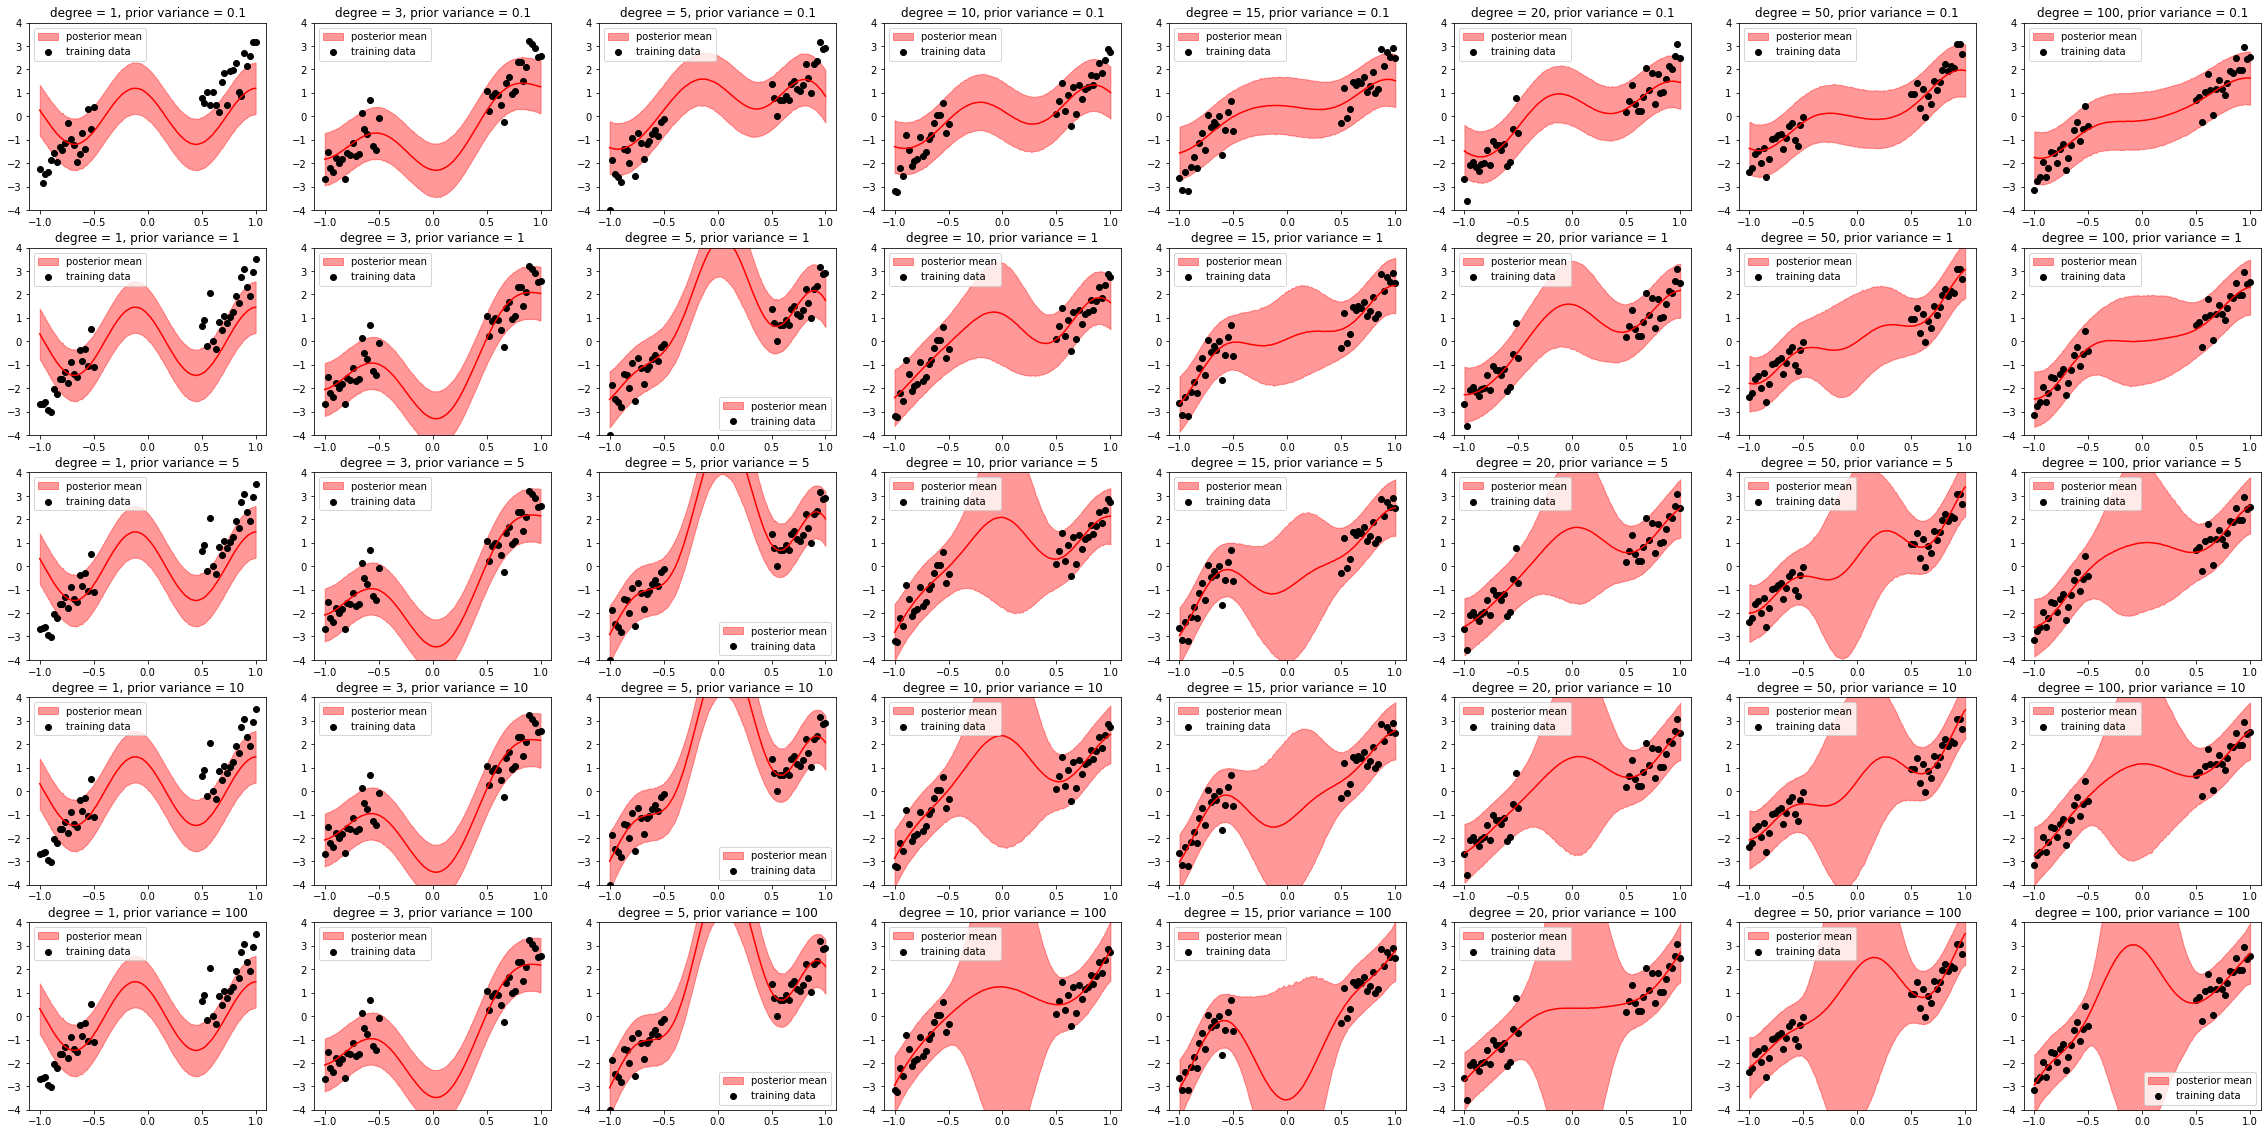

In [13]:
beta = 10

alpha = [0.1, 1, 5, 10, 100]
degrees = [1, 3, 5, 10, 15, 20, 50, 100]

noise_variance = 0.3 
N = 20
trials = 200

fig, ax = plt.subplots(len(alpha), len(degrees), figsize=(40, 20))


for j, sig in enumerate(alpha):
    for k, deg in enumerate(degrees):       
        x_train, y_train, x_test = generate_data(number_of_points=N, noise_variance=noise_variance)
        
        # Apply fourier random feature mapping
        x_train_fourier = generate_random_fourier_features(x_train, beta, deg)
        x_test_fourier = generate_random_fourier_features(x_test, beta, deg)

        # Get samples from the posterior predictive
        posterior_predictions, posterior_predictive_samples = get_posterior_samples(sig, noise_variance, x_train_fourier, y_train.reshape((-1, 1)), x_test_fourier, trials)

        # Compute the 97.5 th percentile of the posterior predictive predictions
        pp_upper = np.percentile(posterior_predictive_samples, 97.5, axis=0)

        # Compute the 2.5 th percentile of the posterior predictive predictions
        pp_lower = np.percentile(posterior_predictive_samples, 2.5, axis=0)

        # Compute the 50 th percentile of the posterior predictive predictions
        pp_mean = np.mean(posterior_predictive_samples, axis=0)

        ax[j, k].plot(x_test, pp_mean, color='red') # visualize the mean of the posterior predictive
        ax[j, k].fill_between(x_test, pp_upper, pp_lower, color='red', alpha=0.4, label='posterior mean') # visualize the 95% posterior predictive interval
        ax[j, k].scatter(x_train, y_train, color='black', label='training data') # visualize the training data

        ax[j, k].legend(loc='best')
        ax[j, k].set_ylim([-4, 4])
        ax[j, k].set_title('degree = {}, prior variance = {}'.format(deg, sig))
        
plt.show()

<font color='#00007B'>

**Interpretation:**

Does the posterior predictive of your Bayesian kernel regression capture important properties of the posterior predictive of the Bayesian polynomial regression model?
    
It captures important properties in bayesian polynomial regression model. It generally shows higher uncertainty when degree increase, and also higher uncertainty when prior variance increase. 
    
However with `degree <=5`, we don't get the expected uncertainties in Bayesian Kernel Regression's posterior predictive uncertainty, it looks pretty certain in the region where our training data are missing, with similar width across all range of x, even with increase of prior variance. We expected a higher uncertainty in the region where data is unseen, and highest uncertainty around x = 0 where it is furthest away from existing data.

3. **(Model Evaluation and Uncertainty Estimation)** Remember that a direct visual comparision of the 95% predictive interval against the training data is impractical! Rather, to evaluate the fit of the Bayesian model on the observed data, we evaluate the marginal log-likelihood of the data under the posterior. Given a test set $\{(\mathbf{x}^*_m, \mathbf{y}^*_m)\}$, the log posterior predictive likelihood or, simply, the **log-likelihood** is computed as:
\begin{align}
\\ \log \prod_{m=1}^M p(\mathbf{y}^*_m | \mathbf{x}^*_m, \text{Data}) &= \sum_{m=1}^M \log p(\mathbf{y}^*_m | \mathbf{x}^*_m, \text{Data})\\
&= \sum_{m=1}^M \log \int_\mathbf{w} p(\mathbf{y}^*_m | \mathbf{x}^*_m, \mathbf{w}) p(\mathbf{w}| \text{Data}) d\mathbf{w}
\end{align}
<br>i.e. the log-likelihood at a single observation $(\mathbf{x}^*_m, \mathbf{y}^*_m)$ is the log of the likelihood of the observation ***averaged over all models in the posterior***. 
<br><br>
For Bayesian linear regression, with posterior $\mathcal{N}(\mu_N, \Sigma_N)$ we have that
$$
p(y^*_m | x^*_m, \text{Data}) = \mathcal{N}(\mu^\top\mathbf{x}^*_m, \sigma^2 + (\mathbf{x}^*_m)^\top\Sigma_N\mathbf{x}^*_m)
$$
where $\sigma^2$ is the variance of the observation noise.
<br><br>
For each choice of $D$ and $\alpha$ in Problem 2, compute the log-likelihood of the training data. Examine a models with the higher log-likelihoods and a few with lower log-likelihoods, what is the relationship between log-likelihood and predictive uncertainty? In particular, does a higher log-likelihood indicate "better" predictive uncertainty?

In [14]:
## log-likehood func to get training data log likelihood
def log_likelihood_compute(prior_var, noise_var, x_matrix, y_matrix):
    '''Function to generate posterior predictive samples for Bayesian linear regression model'''
    prior_variance = np.diag(prior_var * np.ones(x_matrix.shape[1]))
    prior_precision = np.linalg.inv(prior_variance)
    
    # from part 1
    joint_precision = prior_precision + x_matrix.T.dot(x_matrix) / noise_var
    joint_variance = np.linalg.inv(joint_precision)
    joint_mean = joint_variance.dot(x_matrix.T.dot(y_matrix)) / noise_var
    
    log_likelihood = 0
    
    for i in range(len(y_train)):
        # calculate each training data points' log likelihood
        mean = joint_mean.T.dot(x_matrix[i].reshape((-1, 1))).flatten()[0]
        var = noise_var + x_matrix[i].T.dot(joint_variance.dot(x_matrix[i]))
        norm_distribution_pdf = norm(mean, var**0.5).logpdf
        log_likelihood += norm_distribution_pdf(y_matrix[i])
        
    return log_likelihood

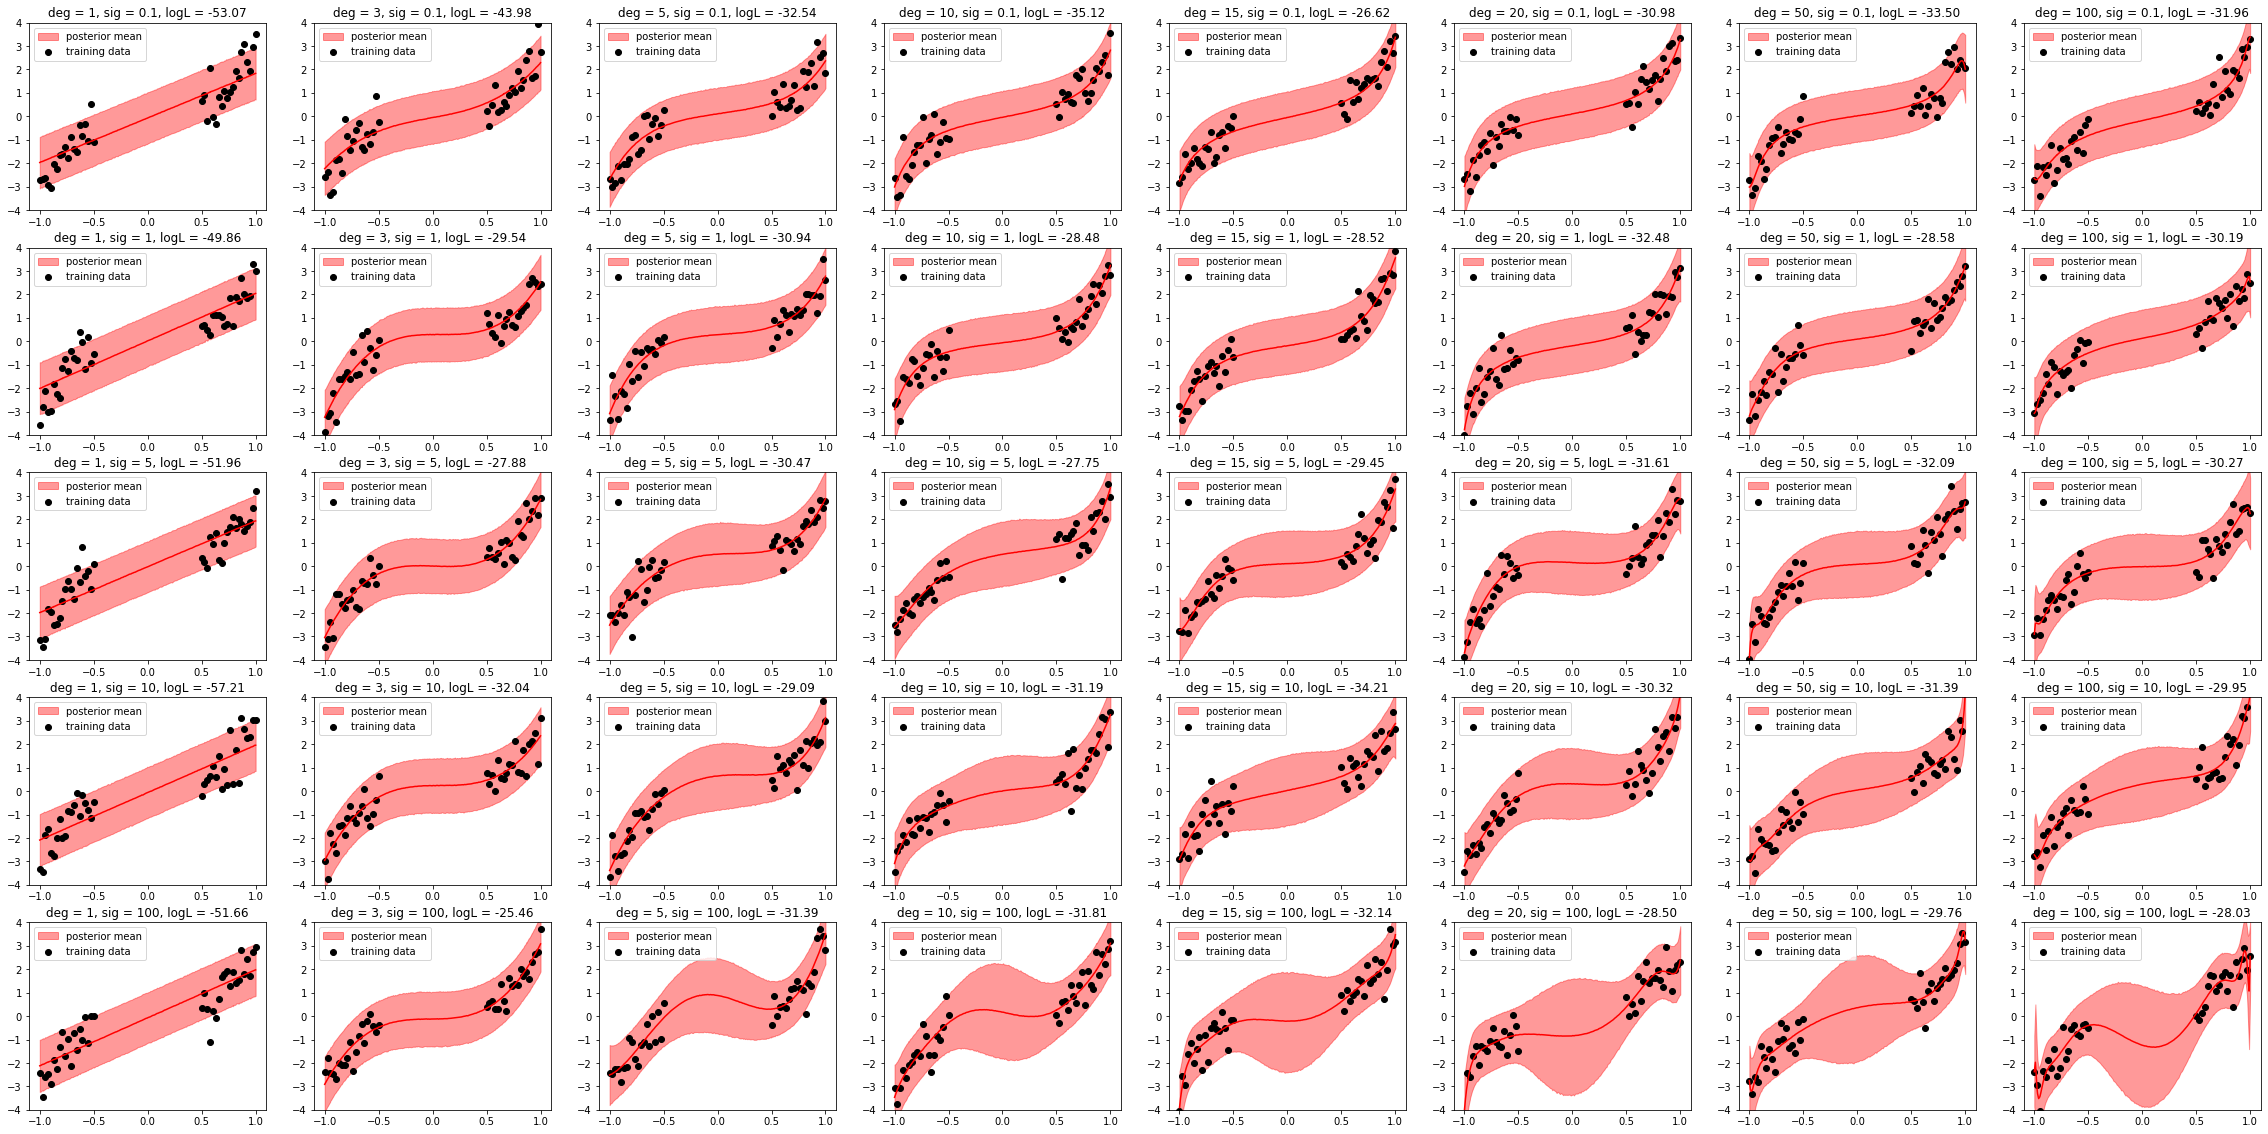

In [15]:
alpha = [0.1, 1, 5, 10, 100]
degrees = [1,3,5,10,15,20,50,100]

noise_variance = 0.3 
N = 20
trials = 200

fig, ax = plt.subplots(len(alpha), len(degrees), figsize=(40, 20))


for j, sig in enumerate(alpha):
    for k, deg in enumerate(degrees):       
        x_train, y_train, x_test = generate_data(number_of_points=N, noise_variance=noise_variance)
        
        # Make an instance of the PolynomialFeatures model to add polynomial powers to our covariates
        poly = PolynomialFeatures(deg)

        # Fit our PolynomialFeatures to our data and add add polynomial powers to our covariates
        x_train_poly = poly.fit_transform(x_train.reshape((-1, 1)))
        x_test_poly = poly.fit_transform(x_test.reshape((-1, 1)))

        # Get samples from the posterior predictive
        posterior_predictions, posterior_predictive_samples = get_posterior_samples(sig, noise_variance, x_train_poly, y_train.reshape((-1, 1)), x_test_poly, trials)

        # Compute the 97.5 th percentile of the posterior predictive predictions
        pp_upper = np.percentile(posterior_predictive_samples, 97.5, axis=0)

        # Compute the 2.5 th percentile of the posterior predictive predictions
        pp_lower = np.percentile(posterior_predictive_samples, 2.5, axis=0)

        # Compute the 50 th percentile of the posterior predictive predictions
        pp_mean = np.mean(posterior_predictive_samples, axis=0)
        
        # compute loglikelihood 
        log_likelihood = log_likelihood_compute(sig, noise_variance, x_train_poly, y_train)

        ax[j, k].plot(x_test, pp_mean, color='red') # visualize the mean of the posterior predictive
        ax[j, k].fill_between(x_test, pp_upper, pp_lower, color='red', alpha=0.4, label='posterior mean') # visualize the 95% posterior predictive interval
        ax[j, k].scatter(x_train, y_train, color='black', label='training data') # visualize the training data

        ax[j, k].legend(loc='best')
        ax[j, k].set_ylim([-4, 4])
        ax[j, k].set_title('deg = {}, sig = {}, logL = {:.2f}'.format(deg, sig, log_likelihood))
        
plt.show()

<font color='#00007B'>

**Interpretation:**

There doesn't seem to be clear trends between log likelihood and predictive uncertainty.

1. The models that has higher log-likelihood are expected to be more likely to observe training data under the current posterior distribution, thus we could observe the model with high loglikehood has posterior predictive distributions that fit the training data better. Though it is still hard to compare in visual graph. When degree = 1, logL is pretty small, it doesn't fit data well, indicating linear posterior doesn't fits well; degree >=3, logL increase dramatically, meaning poly degree fit data better. Comparing with degree =1, we see there's huge increase in loglikelihood, due to complex model fit the training data much better.

2. Observe horizontally, when degree of polynomial gets large, predictive uncertainty gets larger, but no clear trends in loglikehood; loglikelihood goes a bit up then goes a bit down; When hold prior variance same, when degree gets larger (i.e. >=3), all poly model could fit the training data, and all of them have the similar loglikehood. There should not be a massive difference in loglikelihood. 

3. Vertically, however, the pattern is also clear that with the same poly degree, we see larger prior variance lead to larger uncertainty/ posterior variance. 

4. Good Predictive loglikehood doesn't neccessary indicate the model fits data well, it couldn't see overfitting problem by only examing loglikehood. 

## Part III: Broader Impact Analysis

Starting in 2020, major machine learning conferences are beginning to ask authors as well as reviewers to explicitly consider the broader impact of new machine learning methods. To properly evaluate the potential good or harm that a piece of technology (AI or not) can do to the general public, we need to be aware that no technology is deployed in ideal conditions or in perfectly neutral contexts. In order to assess the potential broader impact of technology, we need to analyze the social systems/institutions of which these technologies will become a part.

To help you analyze the broader impact of your technology, begin by considering the following questions:

I. Identify the relevant socio-technical systems
  - In what social, political, economic system could the tech be deployed?
  - How would the tech be used in these systems (what role will it take in the decision making processes)?<br><br>
  
II. Identify the stakeholders
  - Who are the users?
  - Who are the affected communities (are these the users)?
  
    ***Hint:*** users are typically decision makers who will use the technology as decision aids (e.g. doctors), whereas affected communities may be folks who are impacted by these decisions but who are not represented in the decision making process (e.g. patients).<br><br>
    
III. What types of harm can this tech do?
  - What kinds of failures can this tech have?
  - What kinds of direct harm can these failures cause?
  - What kinds of harm can the socio-technical system cause?
  
    ***Hint:*** many technical innovations have niche applications, they may sit in a long chain of decision making in a complex system. As such, it may seem, at first glance, that these technologies have no immediate real-life impact. In these cases, it’s helpful to think about the impact of the entire system and then think about how the proposed innovations aid, hamper or change the goals or outcomes of this system.<br><br>
    
IV. What types of good can this tech do?
  - What kinds of needs do these users/communities have?
  - What kinds of constraints do these users/communities have?

1. **(Impact)**  Analyze the broader impact of these polynomial models. Focus on anticipating ways these models can interact with other components of the decision systems in which they will be deployed, identifying end-users, affected communities as well as anticipating the effects (positive and negative) on affected communities (in particular, does the model have the same effect on all subpopulations in the affected communities?). 

  Specifically address how predictive uncertainty can impact decision making when the models are deployed.

<font color='#00007B'>

**Answer:**

As the model data is a single predictor $X$ representing patient age (normalized) and a single outcome $y$ representing diastolic blood pressure (normalized and rescaled), the deployed model has a similar target end user and affected community in problem set 1. 

In healthcare, from improved disease screening to treatment plan, these model could have huge positive and negative social, economical and political impacts. Policymakers needs to understand these pros and cons, to build policies that amplify the benefits and mitigate the risks. Model developers also need to be part of this conversation: to help anticipate and assess the social impact of its applications, and promote initiatives to steer research and society in beneficial directions.
    
The affected community will be patients, and the end user will be the doctors, healthcare giver, clinics, hospitals etc. There is clearly imbalance of power structure between end user and affected community. In real life, end users will use this model to inform their decision making, and affected community could only passively accept end users' treatment and diagnosis. Patients who are impacted by these decisions may not be represented in the decision making process. For healthcare industry, false negative or false positive cases that diagnose patients' symptons wrongly could result in severe downside consequences. 
    
The **predictive uncertainty**, if not well considered with risk mitigatation, could have negative impact during decision making when the models are deployed. If for those patients that we never observed before (i.e. x that not shown in training data, where covariate shift happens), the predictive uncertainty doesn't display higher uncertainty, doctor could have make decision making with same level of certainty based on existing case, which is not the case we want to see. We definitely want doctor to consider potential downside and risk when comes to treatment plan for some patient case that is rare, or never see before. We shouldn't make decision with same certainty level without bare in mind the higher uncertainty that this model may have.
    
The models also do not have the same effect on all subpopulations in the affected communities. When deploy the model in a real-life clinical setting, as it may be more uncertain for patient with normalized age zero. In real life, for certain subpopulations, it could be much more dangerous to misdiagnose their blood pressure. For example, wrong treatment for patient that we never seen before would be especially problematic. If we proceed with same level of certainty, they may thus receive wrong treatment, miss the critical time to get right treatments, or even lost their life due to wrong treatments.

For end users, their goal might be using the model as a decision making tool to treat patient more efficiently with the most suitable care and treatment possible. 
For affected community, their goal would be get recovered from sickness, disease, or simply a medical check to inform their further action or treatment.
The relationship between end-users and affected communities is important to think about because the interests/goals of end users and the affected community may not always align. And when they do not, as a developer of algorithm and model, we need to be careful about deploying model, and has to make a decision about to whose interest are developers obligated. In this case, patients needs to be specially taken care of because getting the right treatment is a basic human rights and is an essential concern about their health. Technology is no longer value neutral but somehow value laden in this case. We need to educate end user to handle the output with care and disclose more information for them to make informed decision making, or let them incorporate human decision making, more senior doctors with better experience, or open a round table to do a double check before proceeding with any treatment when uncertainty is high.

2. **(Bayesian versus Frequentist Uncertainty)** Compare the types of predictive uncertainties that are generated by Bayesian models and ensembles. Characterize the advantages and disadvantages of bootstrap uncertainties from an ensemble. Describe an situation where it would be better to compute bootstrap uncertainties rather than posterior predictive uncertainties from a Bayesian model.

  ***Hint:*** For example, consider situations where the data is scarce versus situations where the data is abundant; consider situations where clinicians can provide guidance on model selection using domain expertise versus situations where we would not know how patterns in the data would extrapolate to new populations of patients.

  Characterize the advantages and disadvantages of posterior predictive uncertainties from a Bayesian model. Describe an application where it is better to use these uncertainties rather than bootstrap uncertainties from an ensemble.

<font color='#00007B'>

**Answer:**
    
* Ensemble using bootstrap: This method generate extremely large uncertainties when making prediction on x values that has covariate shift and is missing from training data, even with large bootstrap samples. When bootstrap sample is small, even in data rich region, it has high uncertainty. When boostrap sample is large, the data rich region will converge and have small uncertainty. Also, adding regularization may not always align with what we want. Thus, if we have little knowledge in our data for some gap region, and expect a pretty high uncertainy in that region we could probably use bootstrap ensemble method. For example, predicting climate change in regions that we don't have any data before. The challenge will be how many bootstrap sample to use. Generally, we could use bootstrap when data is abundant, however, we must be careful that it won't make uncertainty in data gap region vanishes. Nevertheless, average a lot of boostrap samples could be easy in real life settings comparing to getting posterior bayesian prediction, it may be less computationally heavy and more intuitive. It could have higher interpretability comparing to Bayesian as well. In situations where we would not know how patterns in the data would extrapolate to new populations of patients, we want a model with uncertainty level as we desired to have large uncertainty, so this method may be used, to reflect the real situation that we have little knowledge in the gap region that we didn't encounter any patient before.
    

* Posterior predictive uncertainties from a Bayesian model is sensitive to prior belief and prior variance, as well as our choice of feature map. We are able to get bayesian model only with small number of data observations, without needs of bootstrap in MLE. Thus, when data is scarse, and we have proper prior belief of variance, it may be better to use bootstrap model; however, if we made bad choice of prior and feature map, the uncertainty level could be deviates from what we expected and make no sense for data poor region. However, sampling from posterior predictive could also be a problem, we need to construct our samplers. It may be complicated and computationally demanding. If we could sample from posterior predictive, we should use Bayesian as it has a relatively desired uncertainty level by adjusting degree, prior variance and feature map. It won't be overly large when data size is small, even in data rich area as ensemble method.
When consider situations where clinicians can provide guidance on model selection using domain expertise, they could make decision under uncertainty and provide appropriate prior belief, this method could be considered, uncertainty level is managed without being overly large.
   
    
    
    

3. **(Measuring Uncertainty)** From your experiments, are any of the model evaluation metrics consdiered in this assignment (MSE, log-likelihood) appropriate for evaluating the quality of predictive uncertainty far away from the training data, that is, if we are concerned about the performance of models under covariate shift should we use these metrics to perform model selection? 

  Do our commonly used "best practices" of training machine learning models help or hamper our ability to train models with useful predictive uncertainties?

  What would be a good metric for measuring uncertainty? How would you define "good" uncertainty in the first place?

  ***Hint:*** Can you formulate a definition of "good" uncertainty without referencing a specific down-stream task?

<font color='#00007B'>

**Answer:**
It is hard to formulate a definition of good uncertainty without referencing a specific down-streaming task. It is highly task dependent. In some situation, we want less uncertainty and are less sensitive to the negative consequence of uncertainty region's downside. Even in data poor area, as long as we obtain a model with low MSE and it perform good in testing dataset it would be acceptable. We just want a model that fits our data well and capture trends. However, in some other case such as health care, we have to treat the region that we observe no data with covariate shift with much more care, as the affected community are sensitive to potential risk of downside in the model that uncertainty could bring.

    
If we consider the performance of model under covariate shift, we could see in the region where x training data is unseen, both MSE and loglikehood failed to capture predictive uncertainty. They measure if the model fits data well, but reflecting little knowledge about uncertainty level. Thus, I would say our commonly used best practices of training machine learning models, use metrics to evaluate model perofmrance, doesn't help or it hamper our ability to train models with useful predictive uncertainty, as they failed to evaluate on uncertainty level. And even if they could measure or show uncertainty level, without knowing downstream tasks, we do not even know what uncertainty level we should be expecting.


From our experiments, none of the model evaluation metrics consdiered in this assignment (MSE, log-likelihood) are appropriate for evaluating the quality of predictive uncertainty far away from the training data. If we are concerned about the performance of models under covariate shift, we should not only these metrics to perform model selection. They could be used as a reference of how well model fits the data, however, some other metrics are needed to better evaluate uncertainty level under covariate shift.